In [1]:
import pandas as pd
import pickle as pkl
import numpy as np 
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve, f1_score

plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 600
sns.set()

# Import data

In [2]:
fire_data = pd.DataFrame(pd.read_pickle('data/gridmet3.pkl')).dropna()
fire_data.columns = pd.read_pickle('data/gridmetCols.pkl')

# convert data type
fire_data = fire_data.apply(pd.to_numeric, errors='ignore')
fire_data.day = pd.to_datetime(fire_data.day)

# # remove outliers: might not make sense to do
# fire_num = fire_data.select_dtypes(include=np.number)
# fire_num = fire_num[(np.abs(stats.zscore(fire_num)) < 3).all(axis=1)]
# fire_not = fire_data.select_dtypes(exclude=np.number)
# fire_data = (fire_num.merge(fire_not, left_index=True, right_index=True)
#             .reset_index(drop=True))

fire_data.info()
display(fire_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350592 entries, 0 to 350591
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   day                350592 non-null  datetime64[ns]
 1   season             350592 non-null  object        
 2   burning_index_g    350592 non-null  float64       
 3   relative_humidity  350592 non-null  float64       
 4   air_temperature    350592 non-null  float64       
 5   wind_speed         350592 non-null  float64       
 6   fire               350592 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 18.7+ MB


day  season  burning_index_g  relative_humidity  air_temperature  \
0 2017-01-01  winter              0.0          52.400002       276.100006   
1 2017-01-01  winter              0.0          47.600002       275.399994   
2 2017-01-01  winter              0.0          45.500000       276.799988   
3 2017-01-01  winter              0.0          41.700001       278.100006   
4 2017-01-01  winter              0.0          48.600002       275.600006   

   wind_speed  fire  
0         4.3     0  
1         3.9     0  
2         4.2     0  
3         4.5     0  
4         4.8     0

## Get Sample (n=40000)

In [3]:
fire_samp = fire_data.sample(n=40000, random_state=88)
fire_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 25573 to 276226
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   day                40000 non-null  datetime64[ns]
 1   season             40000 non-null  object        
 2   burning_index_g    40000 non-null  float64       
 3   relative_humidity  40000 non-null  float64       
 4   air_temperature    40000 non-null  float64       
 5   wind_speed         40000 non-null  float64       
 6   fire               40000 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 2.4+ MB


## Convert Season Column to Dummy Variable

In [4]:
fire_samp = (fire_samp.drop(['season'], axis=1)
             .merge(pd.get_dummies(fire_samp.season), 
                    left_index=True, right_index=True))
fire_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 25573 to 276226
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   day                40000 non-null  datetime64[ns]
 1   burning_index_g    40000 non-null  float64       
 2   relative_humidity  40000 non-null  float64       
 3   air_temperature    40000 non-null  float64       
 4   wind_speed         40000 non-null  float64       
 5   fire               40000 non-null  int64         
 6   autumn             40000 non-null  uint8         
 7   spring             40000 non-null  uint8         
 8   summer             40000 non-null  uint8         
 9   winter             40000 non-null  uint8         
dtypes: datetime64[ns](1), float64(4), int64(1), uint8(4)
memory usage: 3.3 MB


## Split into train and test

In [5]:
y = fire_samp['fire']
X = fire_samp.drop(columns=['fire', 'day'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 8), (12000, 8), (28000,), (12000,))

In [6]:
X_train.select_dtypes(exclude='uint8').columns

Index(['burning_index_g', 'relative_humidity', 'air_temperature',
       'wind_speed'],
      dtype='object')

# Models

In [7]:
# remove numerical columns with VIF > 5; not dummy variables
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

VIF(X_train, X_train.select_dtypes(exclude='uint8').columns)

burning_index_g      2.868814
relative_humidity    3.283416
air_temperature      2.499513
wind_speed           1.292017
dtype: float64

In [8]:
def scores(y_test, y_pred):
    cm  = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    TPR = cm[1][1] / sum(cm[1])            # TP/(TP+FN)
    FPR = cm[0][1] / sum(cm[0])            # FP/(FP+TN)
    PRE = cm[1][1] / (cm[0][1] + cm[1][1]) # TP/(TP+FP)
    f1  = f1_score(y_test, y_pred)
    print(f'Accuracy: {acc:.4f}, TPR: {TPR:.4f}, FPR: {FPR:.4f}, Precision: {PRE:.4f}, f1: {f1:.4f}')
    return acc, TPR, FPR, PRE, f1

## Baseline

In [9]:
cm = confusion_matrix(y_test,[0]*y_test.shape[0])
common = y_train.value_counts().index[0]
baseline_acc = y_test.value_counts()[common] / len(y_test)
baseline_TPR = cm[1][1] / sum(cm[1])
baseline_FPR = cm[0][1] / sum(cm[0])
baseline_PRE = 0 
baseline_f1  = 0
print(f'Accuracy: {baseline_acc:.4f}, TPR: {baseline_TPR:.4f}, FPR: {baseline_FPR:.4f}, Precision: {baseline_PRE:.4f}, f1: {baseline_f1:.4f}')

Accuracy: 0.6590, TPR: 0.0000, FPR: 0.0000, Precision: 0.0000, f1: 0.0000


## Logistic Regression

In [10]:
log = LogisticRegression(random_state=88, max_iter=200)
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
log_acc,log_TPR,log_FPR,log_PRE,log_f1 = scores(y_test, y_pred)

Accuracy: 0.7693, TPR: 0.7324, FPR: 0.2116, Precision: 0.6418, f1: 0.6841


## CART: Decision Tree Classification

In [11]:
# without cross validation 
dtc = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=20, 
                             random_state=88)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
dtc_acc,dtc_TPR,dtc_FPR,dtc_PRE,dtc_f1 = scores(y_test, y_pred)

Accuracy: 0.7525, TPR: 0.6249, FPR: 0.1815, Precision: 0.6405, f1: 0.6326


In [12]:
# with cross validation 
grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'random_state': [88]}

dtc_c = DecisionTreeClassifier(random_state=88)
dtc_cv = GridSearchCV(dtc_c, param_grid=grid_values, scoring='f1', cv=10) 
dtc_cv.fit(X_train, y_train)
y_pred = dtc_cv.best_estimator_.predict(X_test)

cart_best_ccp_alpha = dtc_cv.best_params_['ccp_alpha']
print(f'Best ccp_alpha: {cart_best_ccp_alpha:.4f}')
dtc_cv_acc,dtc_cv_TPR,dtc_cv_FPR,dtc_cv_PRE,dtc_cv_f1 = scores(y_test, y_pred)

Best ccp_alpha: 0.0005
Accuracy: 0.7858, TPR: 0.7583, FPR: 0.1999, Precision: 0.6625, f1: 0.7072


## Vanilla Bagging

In [13]:
vb = RandomForestClassifier(max_features=X_train.shape[1], random_state=88)
vb.fit(X_train, y_train)
y_pred = vb.predict(X_test)

vb_acc,vb_TPR,vb_FPR,vb_PRE,vb_f1 = scores(y_test, y_pred)

Accuracy: 0.7803, TPR: 0.6984, FPR: 0.1773, Precision: 0.6709, f1: 0.6844


## Random Forest

In [14]:
# without cross validation
rf = RandomForestClassifier(min_samples_leaf=5, min_samples_split=20, 
                            random_state=88)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf_acc,rf_TPR,rf_FPR,rf_PRE,rf_f1 = scores(y_test, y_pred)

Accuracy: 0.7917, TPR: 0.7539, FPR: 0.1887, Precision: 0.6740, f1: 0.7117


In [15]:
# with cross validation 
grid_values = {'max_features': np.arange(1, X_train.shape[1]),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]}

rf_c = RandomForestClassifier(random_state=88)
rf_cv = GridSearchCV(rf_c, param_grid=grid_values, scoring='f1', cv=10)
rf_cv.fit(X_train, y_train)

y_pred = rf_cv.predict(X_test)

rf_max_features = rf_cv.best_params_['max_features']
print(f'Best max_features: {rf_max_features}')
rf_cv_acc,rf_cv_TPR,rf_cv_FPR,rf_cv_PRE,rf_cv_f1 = scores(y_test, y_pred)

Best max_features: 1
Accuracy: 0.7927, TPR: 0.7549, FPR: 0.1877, Precision: 0.6755, f1: 0.7130


## Linear Discriminant Analysis

In [16]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
lda_acc,lda_TPR,lda_FPR,lda_PRE,lda_f1 = scores(y_test, y_pred)

Accuracy: 0.7687, TPR: 0.7671, FPR: 0.2305, Precision: 0.6326, f1: 0.6934


## Gradient Boosting Classifier

In [17]:
gbc = GradientBoostingClassifier(n_estimators=500, max_leaf_nodes=10, 
                                 random_state=88) 
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
gbc_acc,gbc_TPR,gbc_FPR,gbc_PRE,gbc_f1 = scores(y_test, y_pred)

Accuracy: 0.7904, TPR: 0.7610, FPR: 0.1944, Precision: 0.6695, f1: 0.7123


# Comparison table

In [18]:
comp = {'Baseline':[baseline_acc,baseline_TPR,baseline_FPR,baseline_PRE,baseline_f1],
        'Logistic Regression':[log_acc,log_TPR,log_FPR,log_PRE,log_f1],
        'Decision Tree Classifier':[dtc_acc,dtc_TPR,dtc_FPR,dtc_PRE,dtc_f1],
        'Decision Tree Classifier with CV':[dtc_cv_acc,dtc_cv_TPR,dtc_cv_FPR,dtc_cv_PRE,dtc_cv_f1],
        'Vanilla Bagging':[vb_acc,vb_TPR,vb_FPR,vb_PRE,vb_f1],
        'Random Forest':[rf_acc,rf_TPR, rf_FPR,rf_PRE,rf_f1],
        'Random Forest with CV':[rf_cv_acc,rf_cv_TPR,rf_cv_FPR,rf_cv_PRE,rf_cv_f1],
        'Linear Discriminant Analysis':[lda_acc,lda_TPR, lda_FPR,lda_PRE,lda_f1],
        'Gradient Boosting Classifier':[gbc_acc,gbc_TPR,gbc_FPR,gbc_PRE,gbc_f1],
        }

df = pd.DataFrame(data=comp, index=['Accuracy', 'TPR', 'FPR','Precision','F1']).transpose()
df.sort_values(['F1'], ascending=False)

Accuracy       TPR       FPR  Precision  \
Random Forest with CV             0.792750  0.754888  0.187658   0.675487   
Gradient Boosting Classifier      0.790417  0.760997  0.194360   0.669533   
Random Forest                     0.791750  0.753910  0.188670   0.674022   
Decision Tree Classifier with CV  0.785833  0.758309  0.199924   0.662468   
Linear Discriminant Analysis      0.768667  0.767107  0.230526   0.632608   
Vanilla Bagging                   0.780333  0.698436  0.177289   0.670892   
Logistic Regression               0.769333  0.732405  0.211558   0.641756   
Decision Tree Classifier          0.752500  0.624878  0.181462   0.640531   
Baseline                          0.659000  0.000000  0.000000   0.000000   

                                        F1  
Random Forest with CV             0.712983  
Gradient Boosting Classifier      0.712341  
Random Forest                     0.711731  
Decision Tree Classifier with CV  0.707156  
Linear Discriminant Analysis      0.693395  
Vanilla Bagging                   0.684387  
Logistic Regression               0.684090  
Decision Tree Classifier          0.632608  
Baseline                          0.000000

In [19]:
print('Factor=3 Comparison Table')
display(df[['TPR', 'Precision', 'F1']])#.sort_values(['F1'], ascending=False))

Factor=3 Comparison Table


TPR  Precision        F1
Baseline                          0.000000   0.000000  0.000000
Logistic Regression               0.732405   0.641756  0.684090
Decision Tree Classifier          0.624878   0.640531  0.632608
Decision Tree Classifier with CV  0.758309   0.662468  0.707156
Vanilla Bagging                   0.698436   0.670892  0.684387
Random Forest                     0.753910   0.674022  0.711731
Random Forest with CV             0.754888   0.675487  0.712983
Linear Discriminant Analysis      0.767107   0.632608  0.693395
Gradient Boosting Classifier      0.760997   0.669533  0.712341

# Bootstrap

In [20]:
def perform_bootstrap(X_test, y_test, models: dict, sample=500, random_state=88):
    np.random.seed(88)
    results = dict()
    for m in range(len(models)):
        results[list(models.keys())[m]] = []
    for bs_iter in range(sample):
        bs_index = np.random.choice(X_test.index, len(X_test.index), replace=True)
        bs_data = X_test.loc[bs_index]
        bs_test = y_test.loc[bs_index]
        for m in range(len(models)):
            model = list(models.values())[m]
            bs_pred = model.predict(bs_data)
            cm = confusion_matrix(bs_test, bs_pred)
            acc = accuracy_score(bs_test, bs_pred)
            TPR = cm[1][1] / sum(cm[1])
            FPR = cm[0][1] / sum(cm[0])
            PRE = cm[1][1] / (cm[0][1] + cm[1][1])
            f1  = f1_score(bs_test, bs_pred)
            results[list(models.keys())[m]].append([acc, TPR, FPR, PRE, f1])
    return results

In [21]:
models = {'Logistic Regression':log,
          'Decision Tree Classifier':dtc,
          'Decision Tree Classifier with CV':dtc_cv,
          'Vanilla Bagging':vb,
          'Random Forest':rf,
          'Random Forest with CV':rf_cv,
          'Linear Discriminant Analysis':lda,
          'Gradient Boosting Classifier':gbc,
          }

In [22]:
# [acc, TPR, FPR, pre, f1]
bs = perform_bootstrap(X_test, y_test, models, sample=1000)

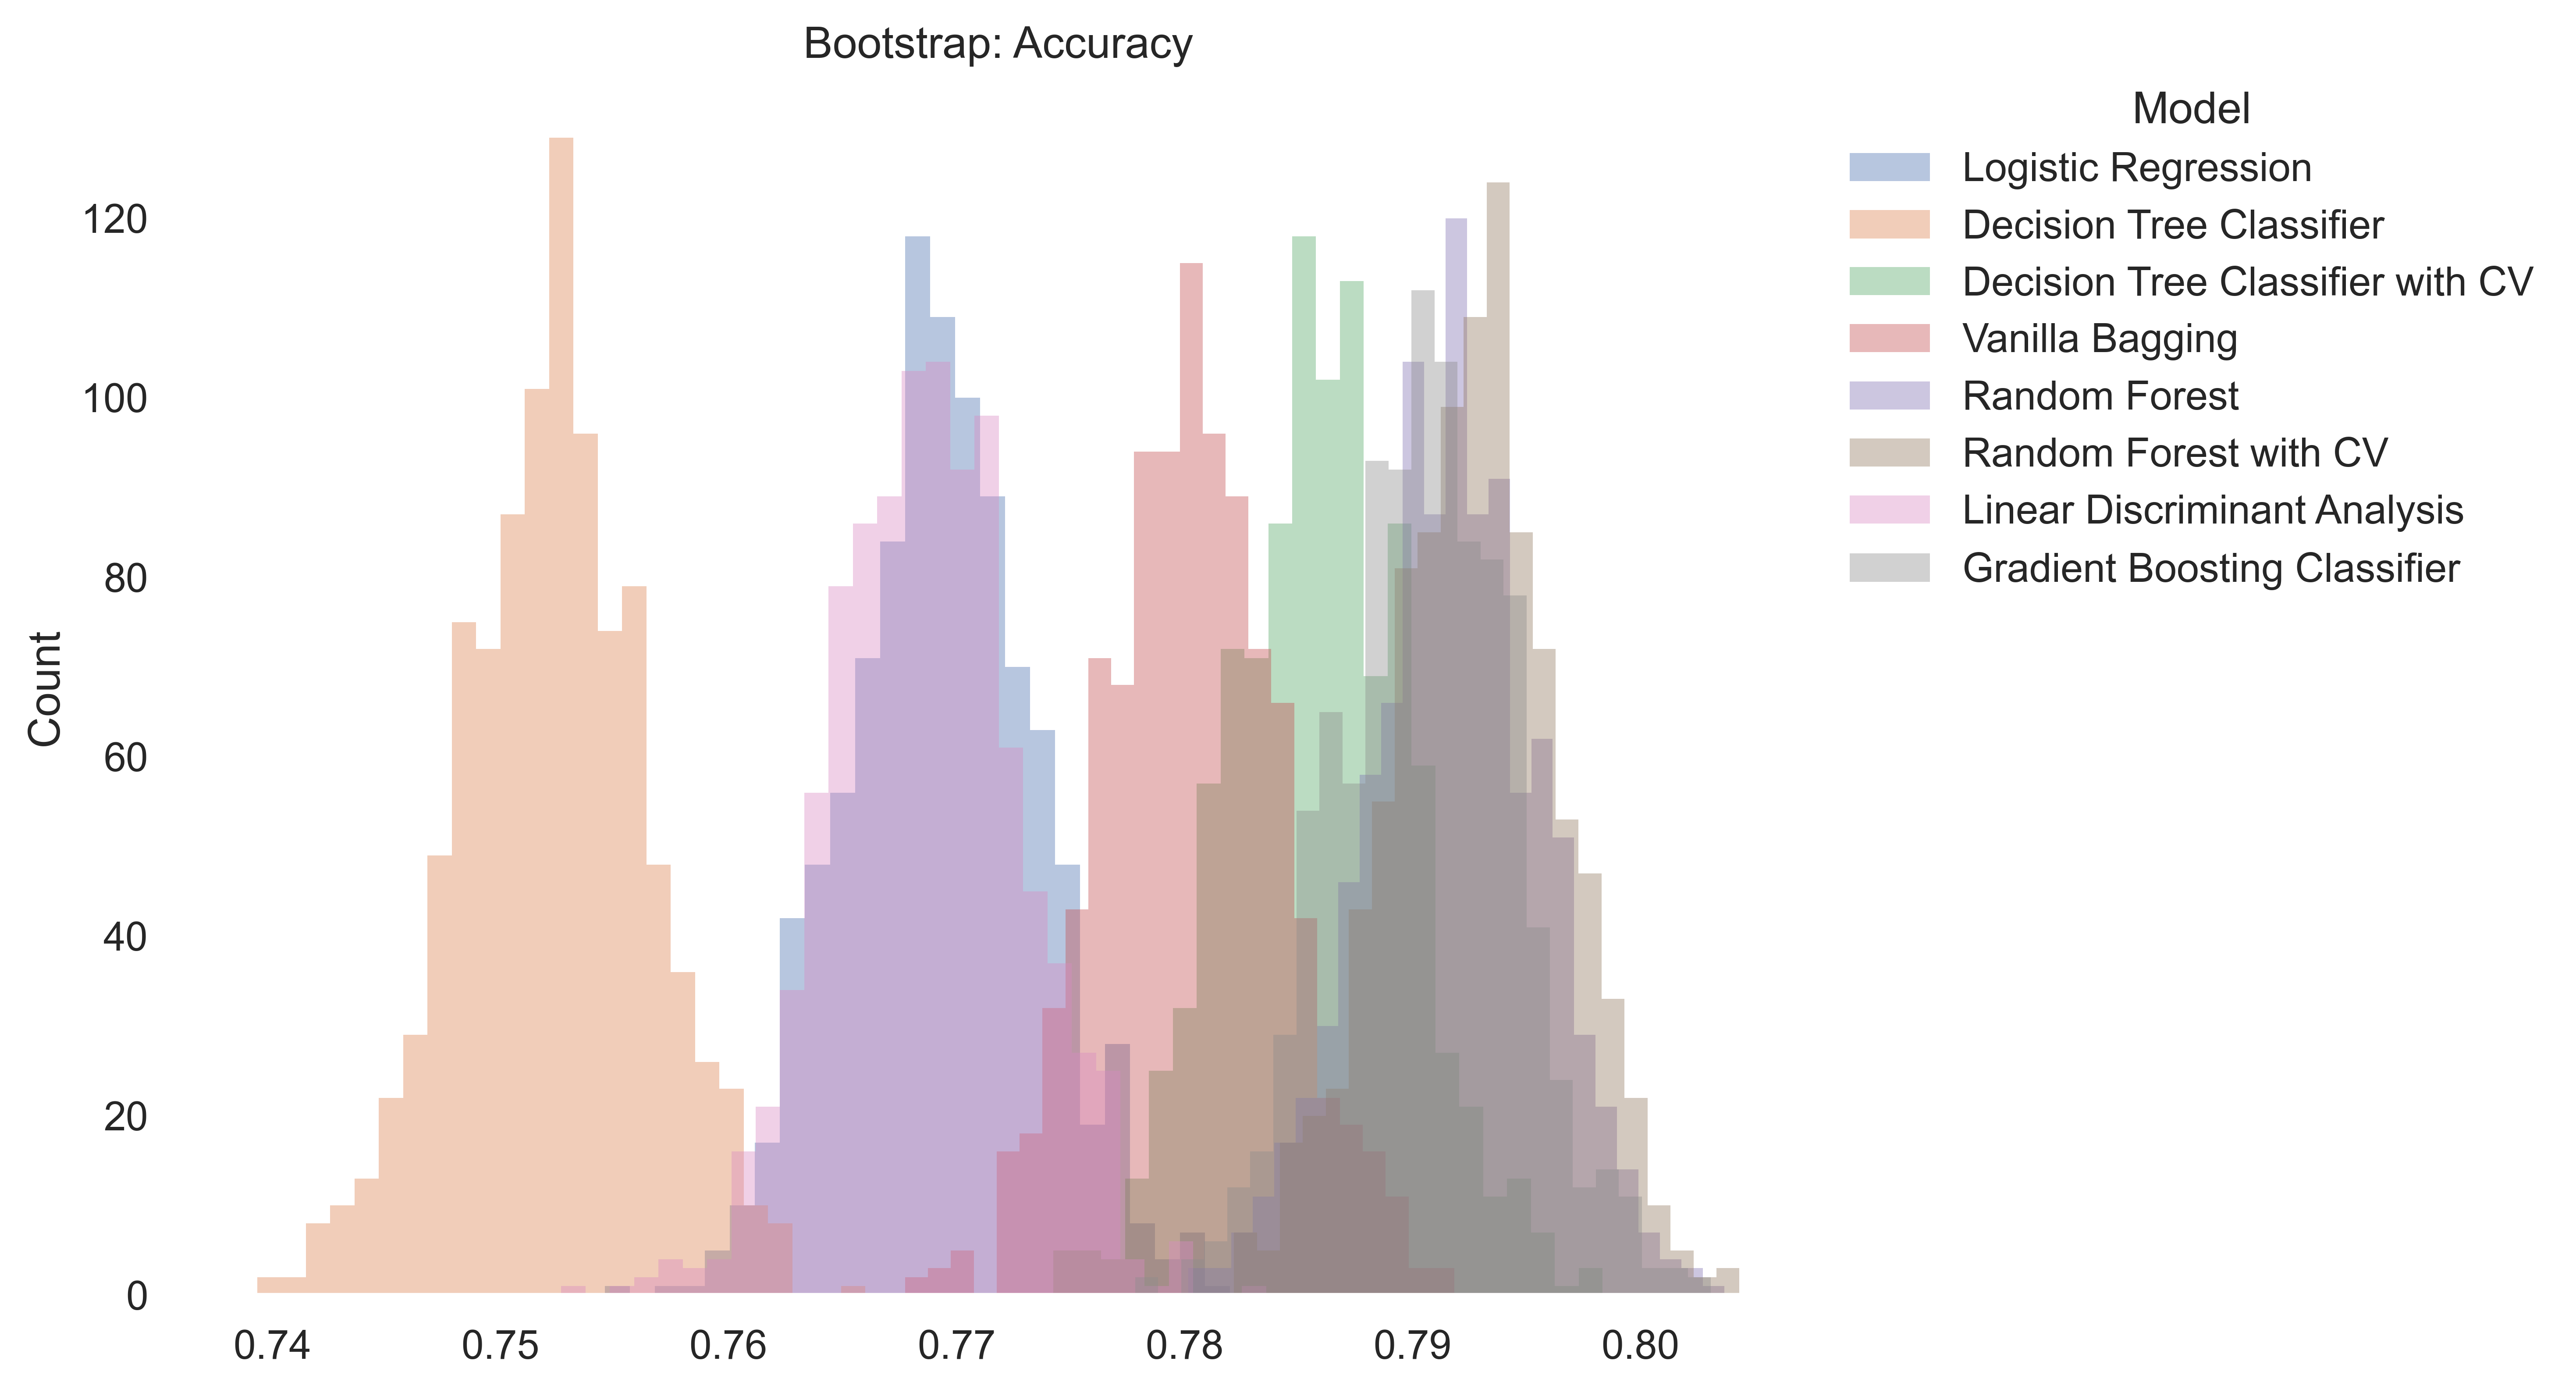

In [23]:
# Bootstrap: Accuracy
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,0], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: Accuracy');
plt.legend(title='Model', labels=list(bs.keys()), 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

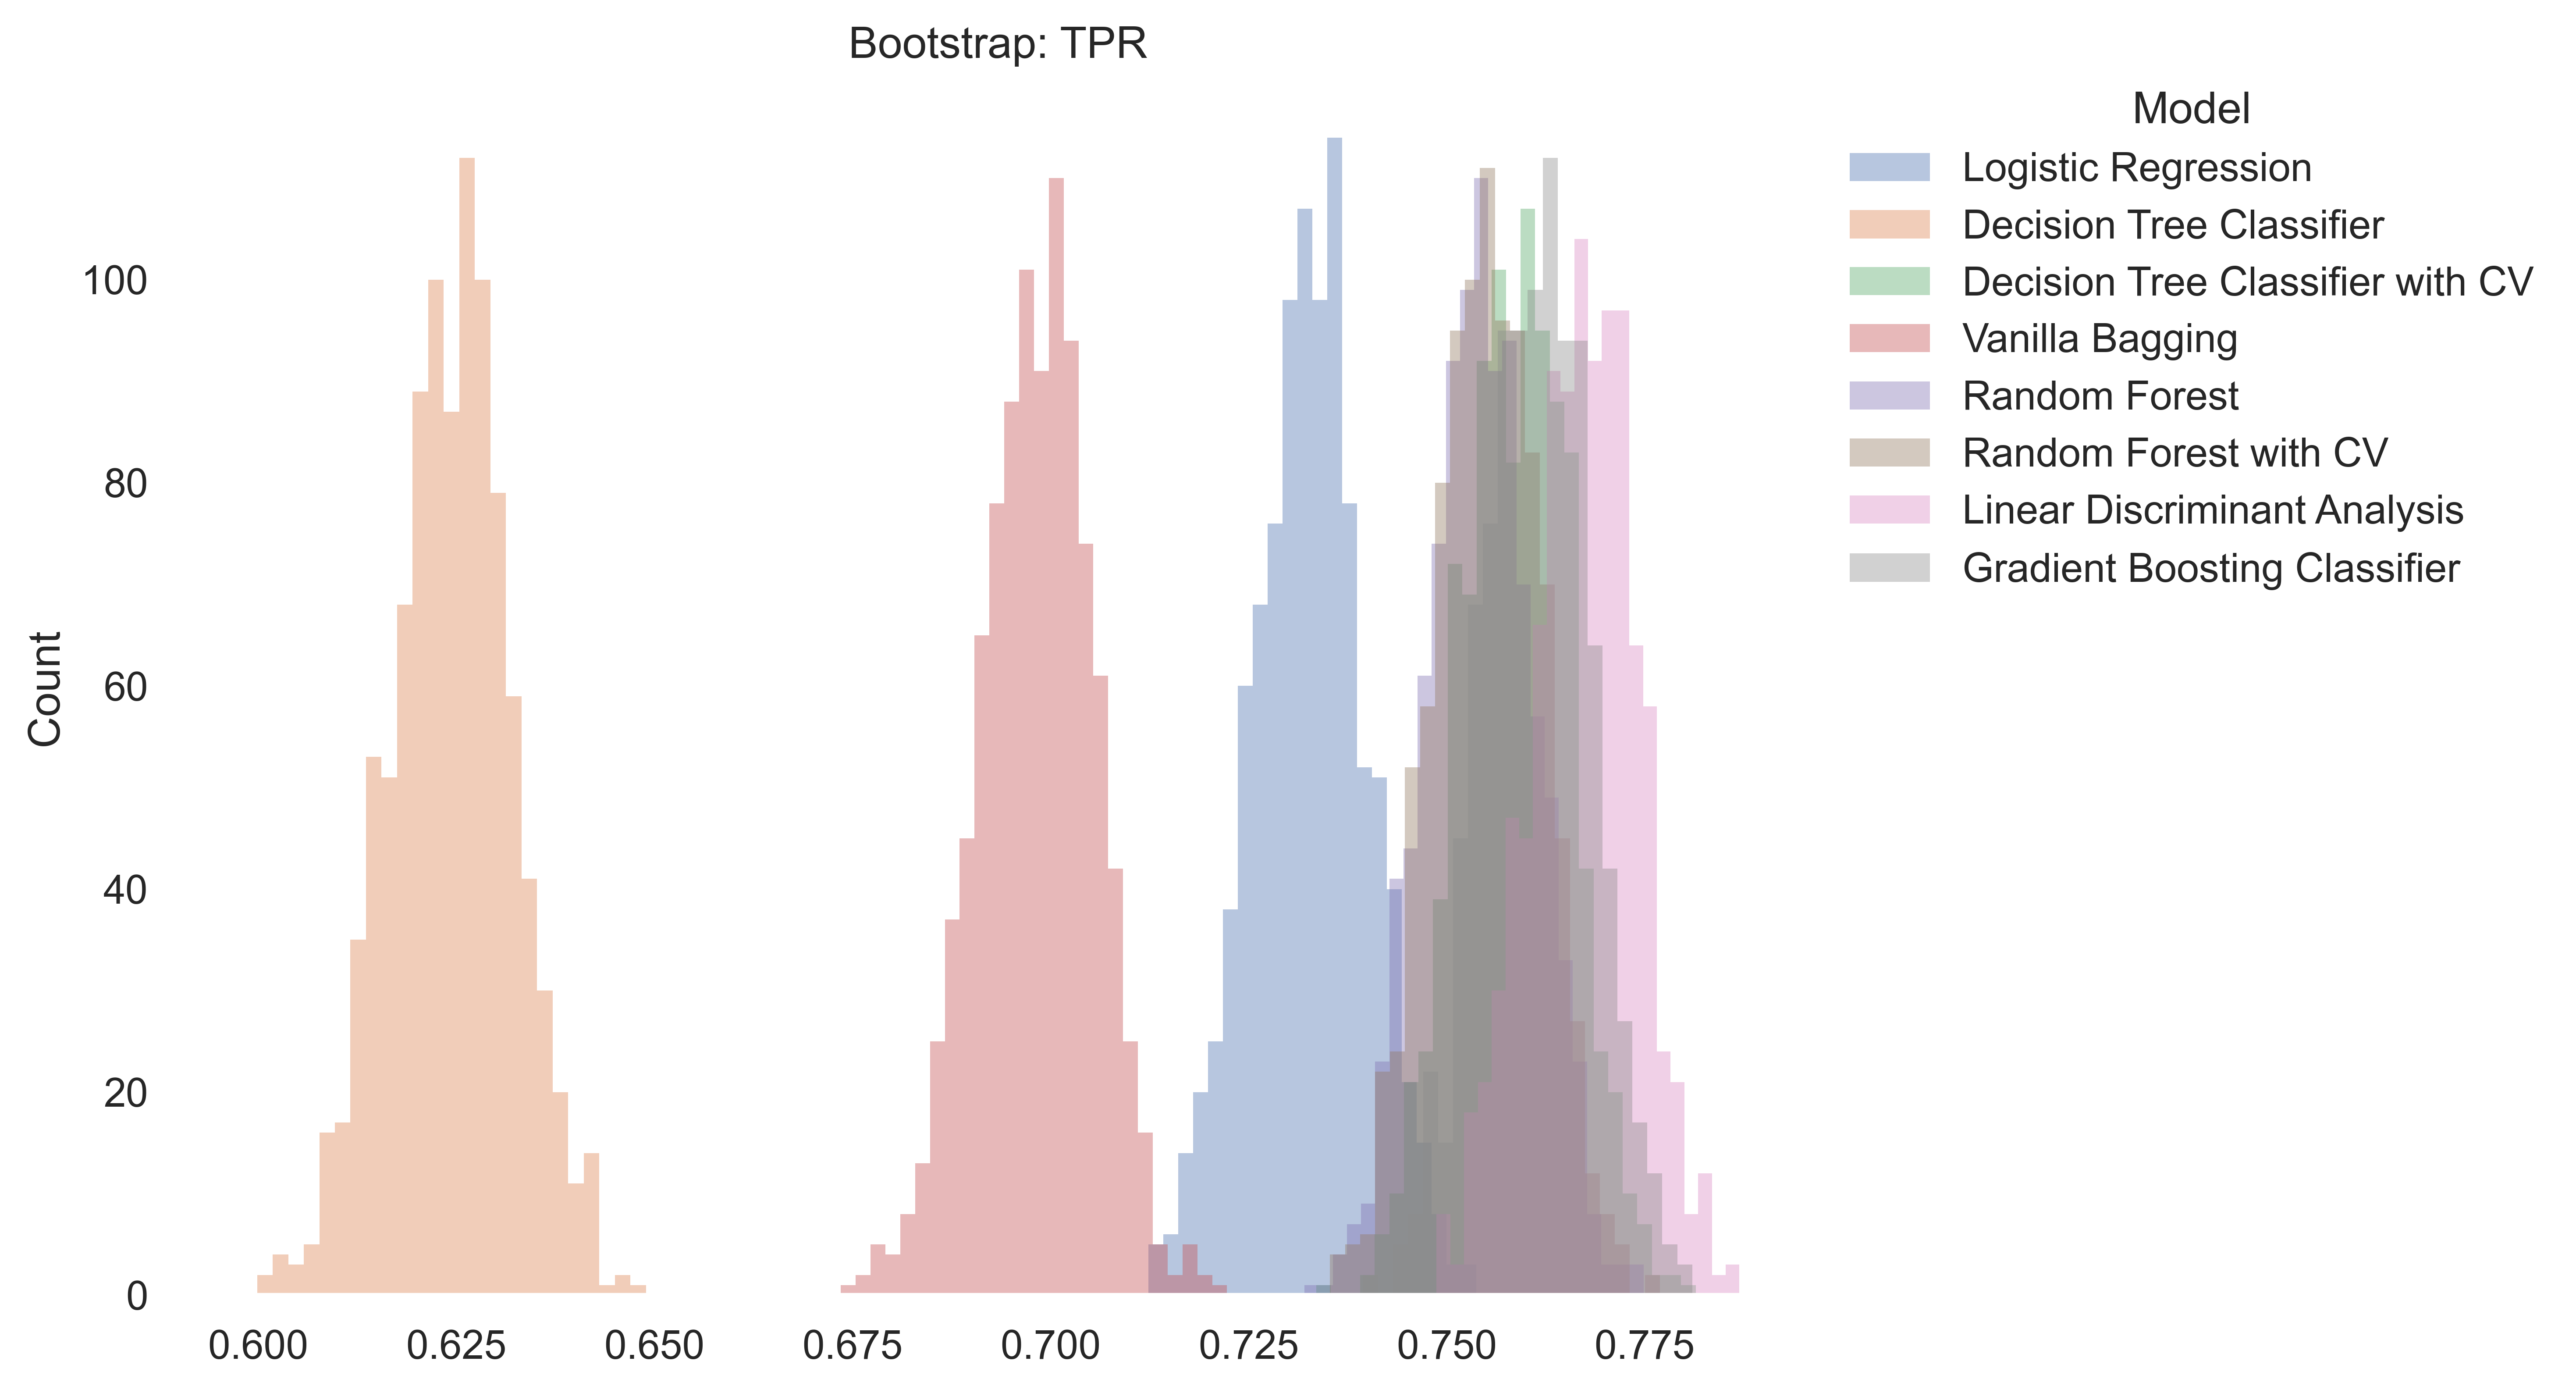

In [24]:
# Bootstrap: TPR
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,1], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: TPR');
plt.legend(title='Model', labels=list(bs.keys()), 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

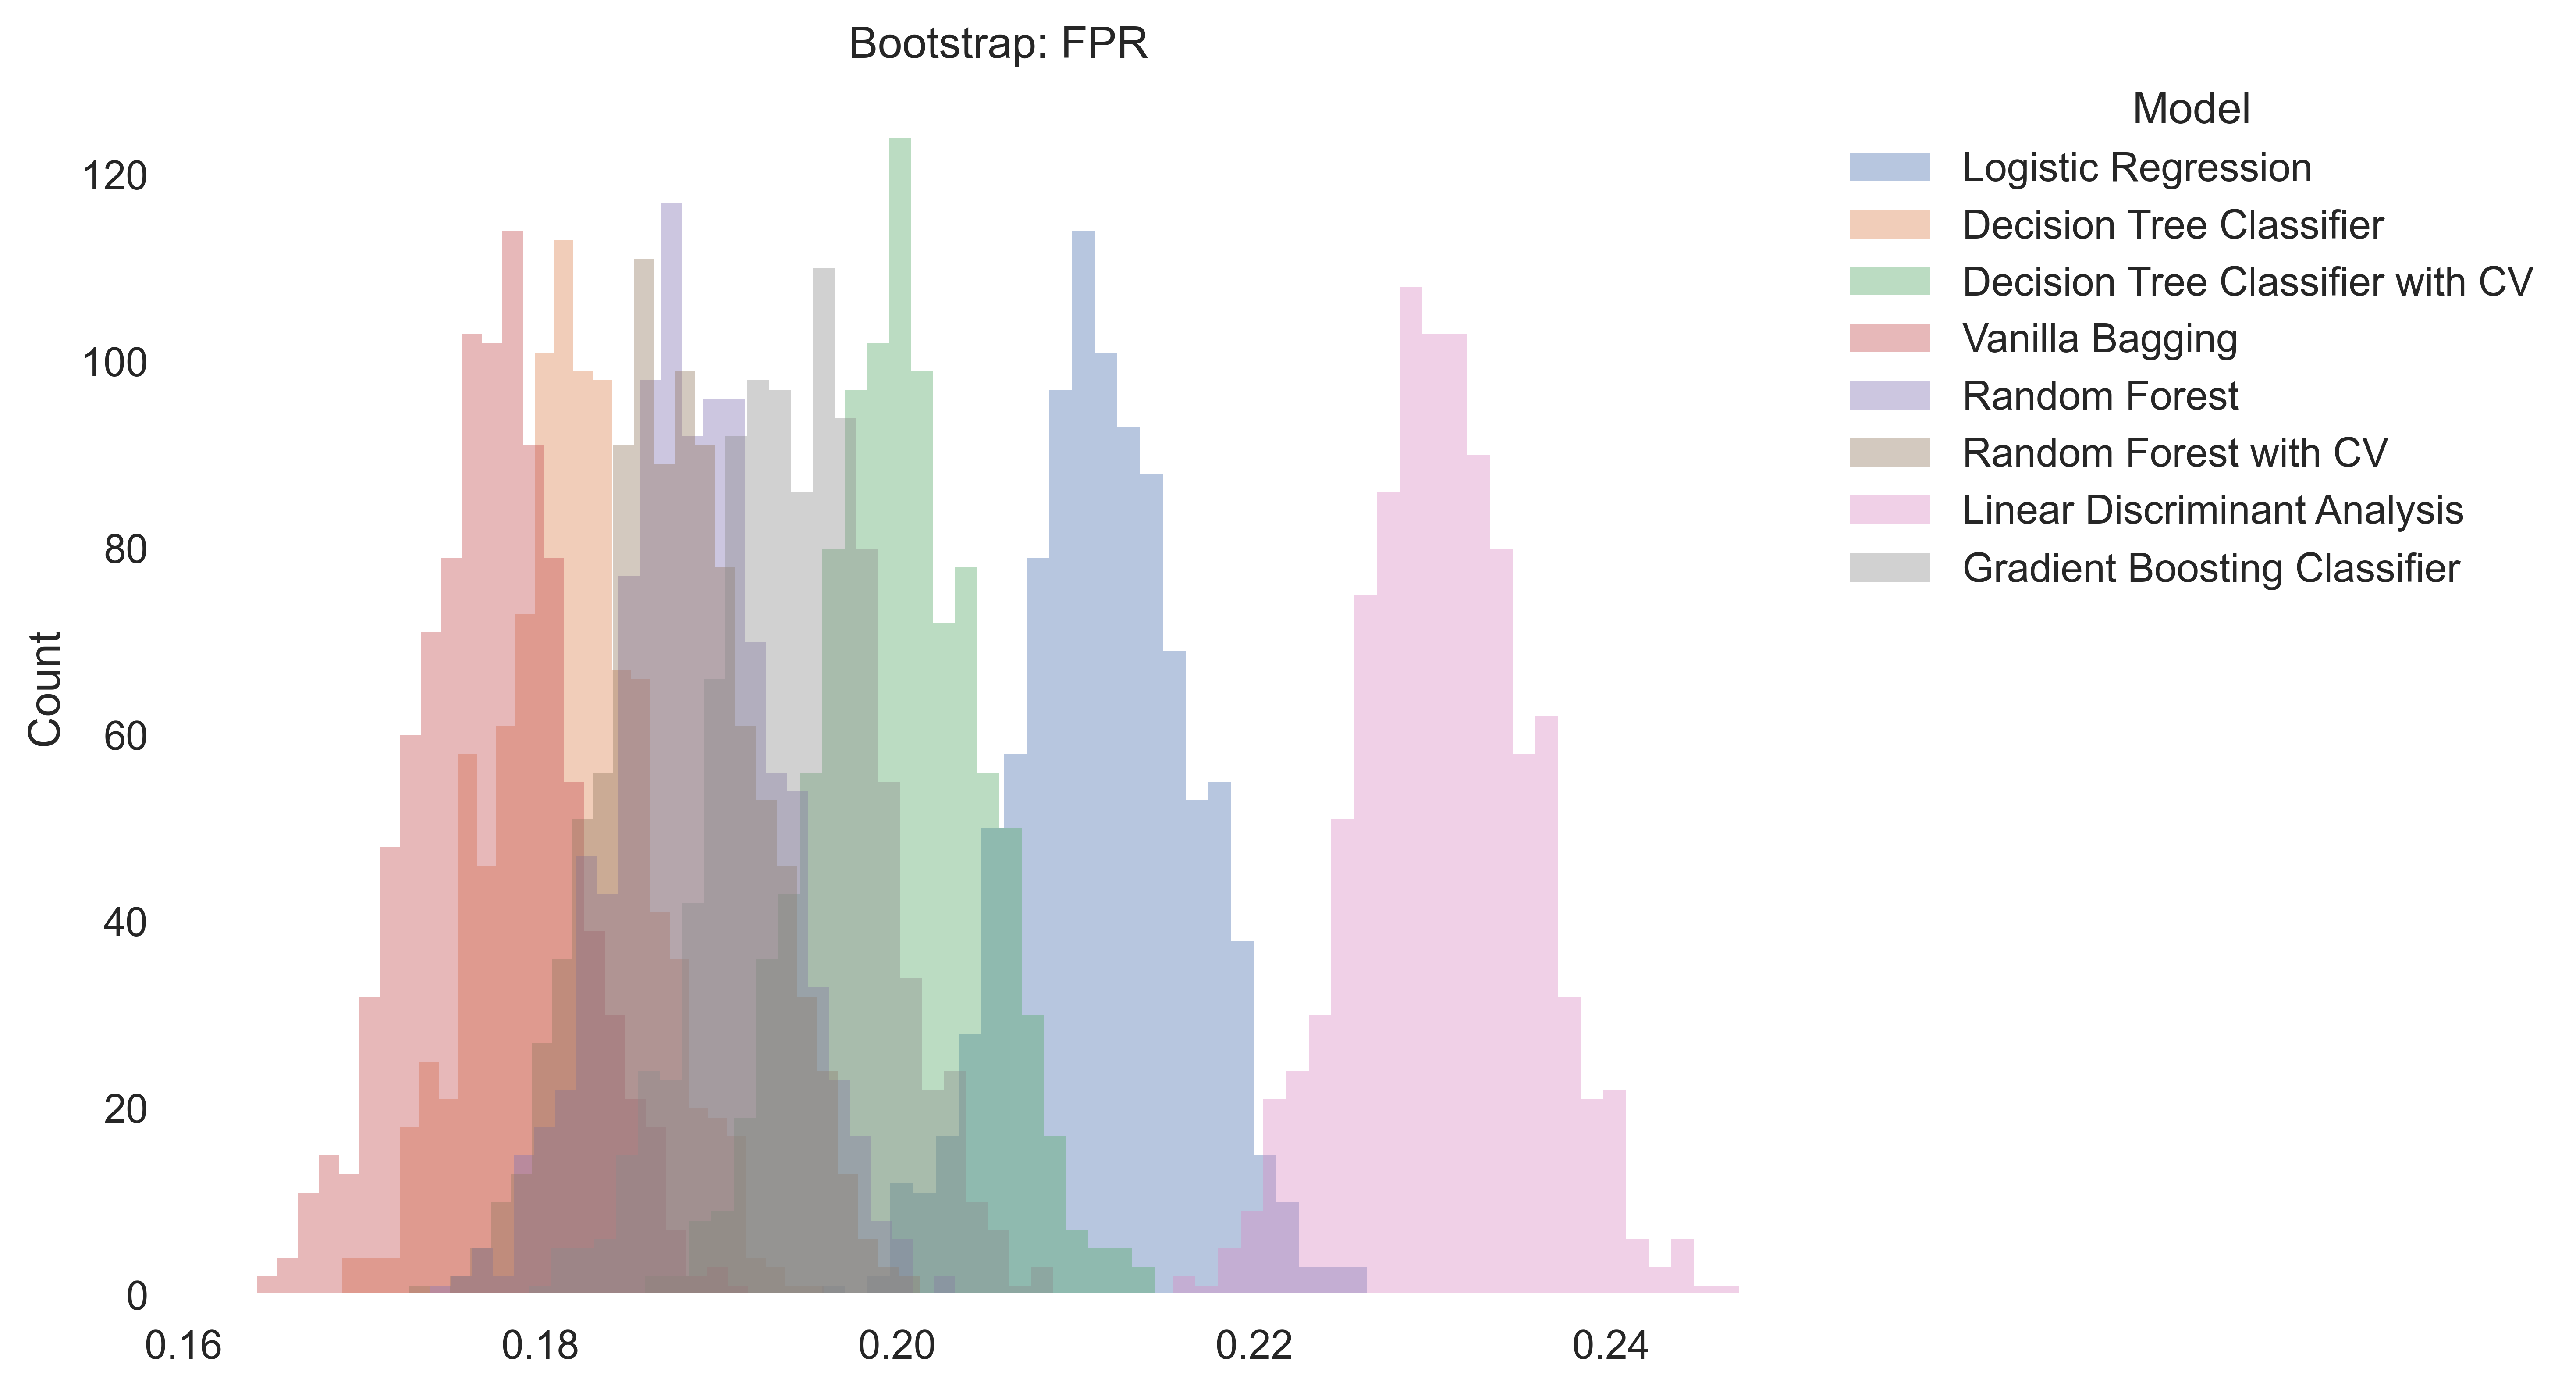

In [25]:
# Bootstrap: FPR
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,2], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: FPR');
plt.legend(title='Model', labels=list(bs.keys()), 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

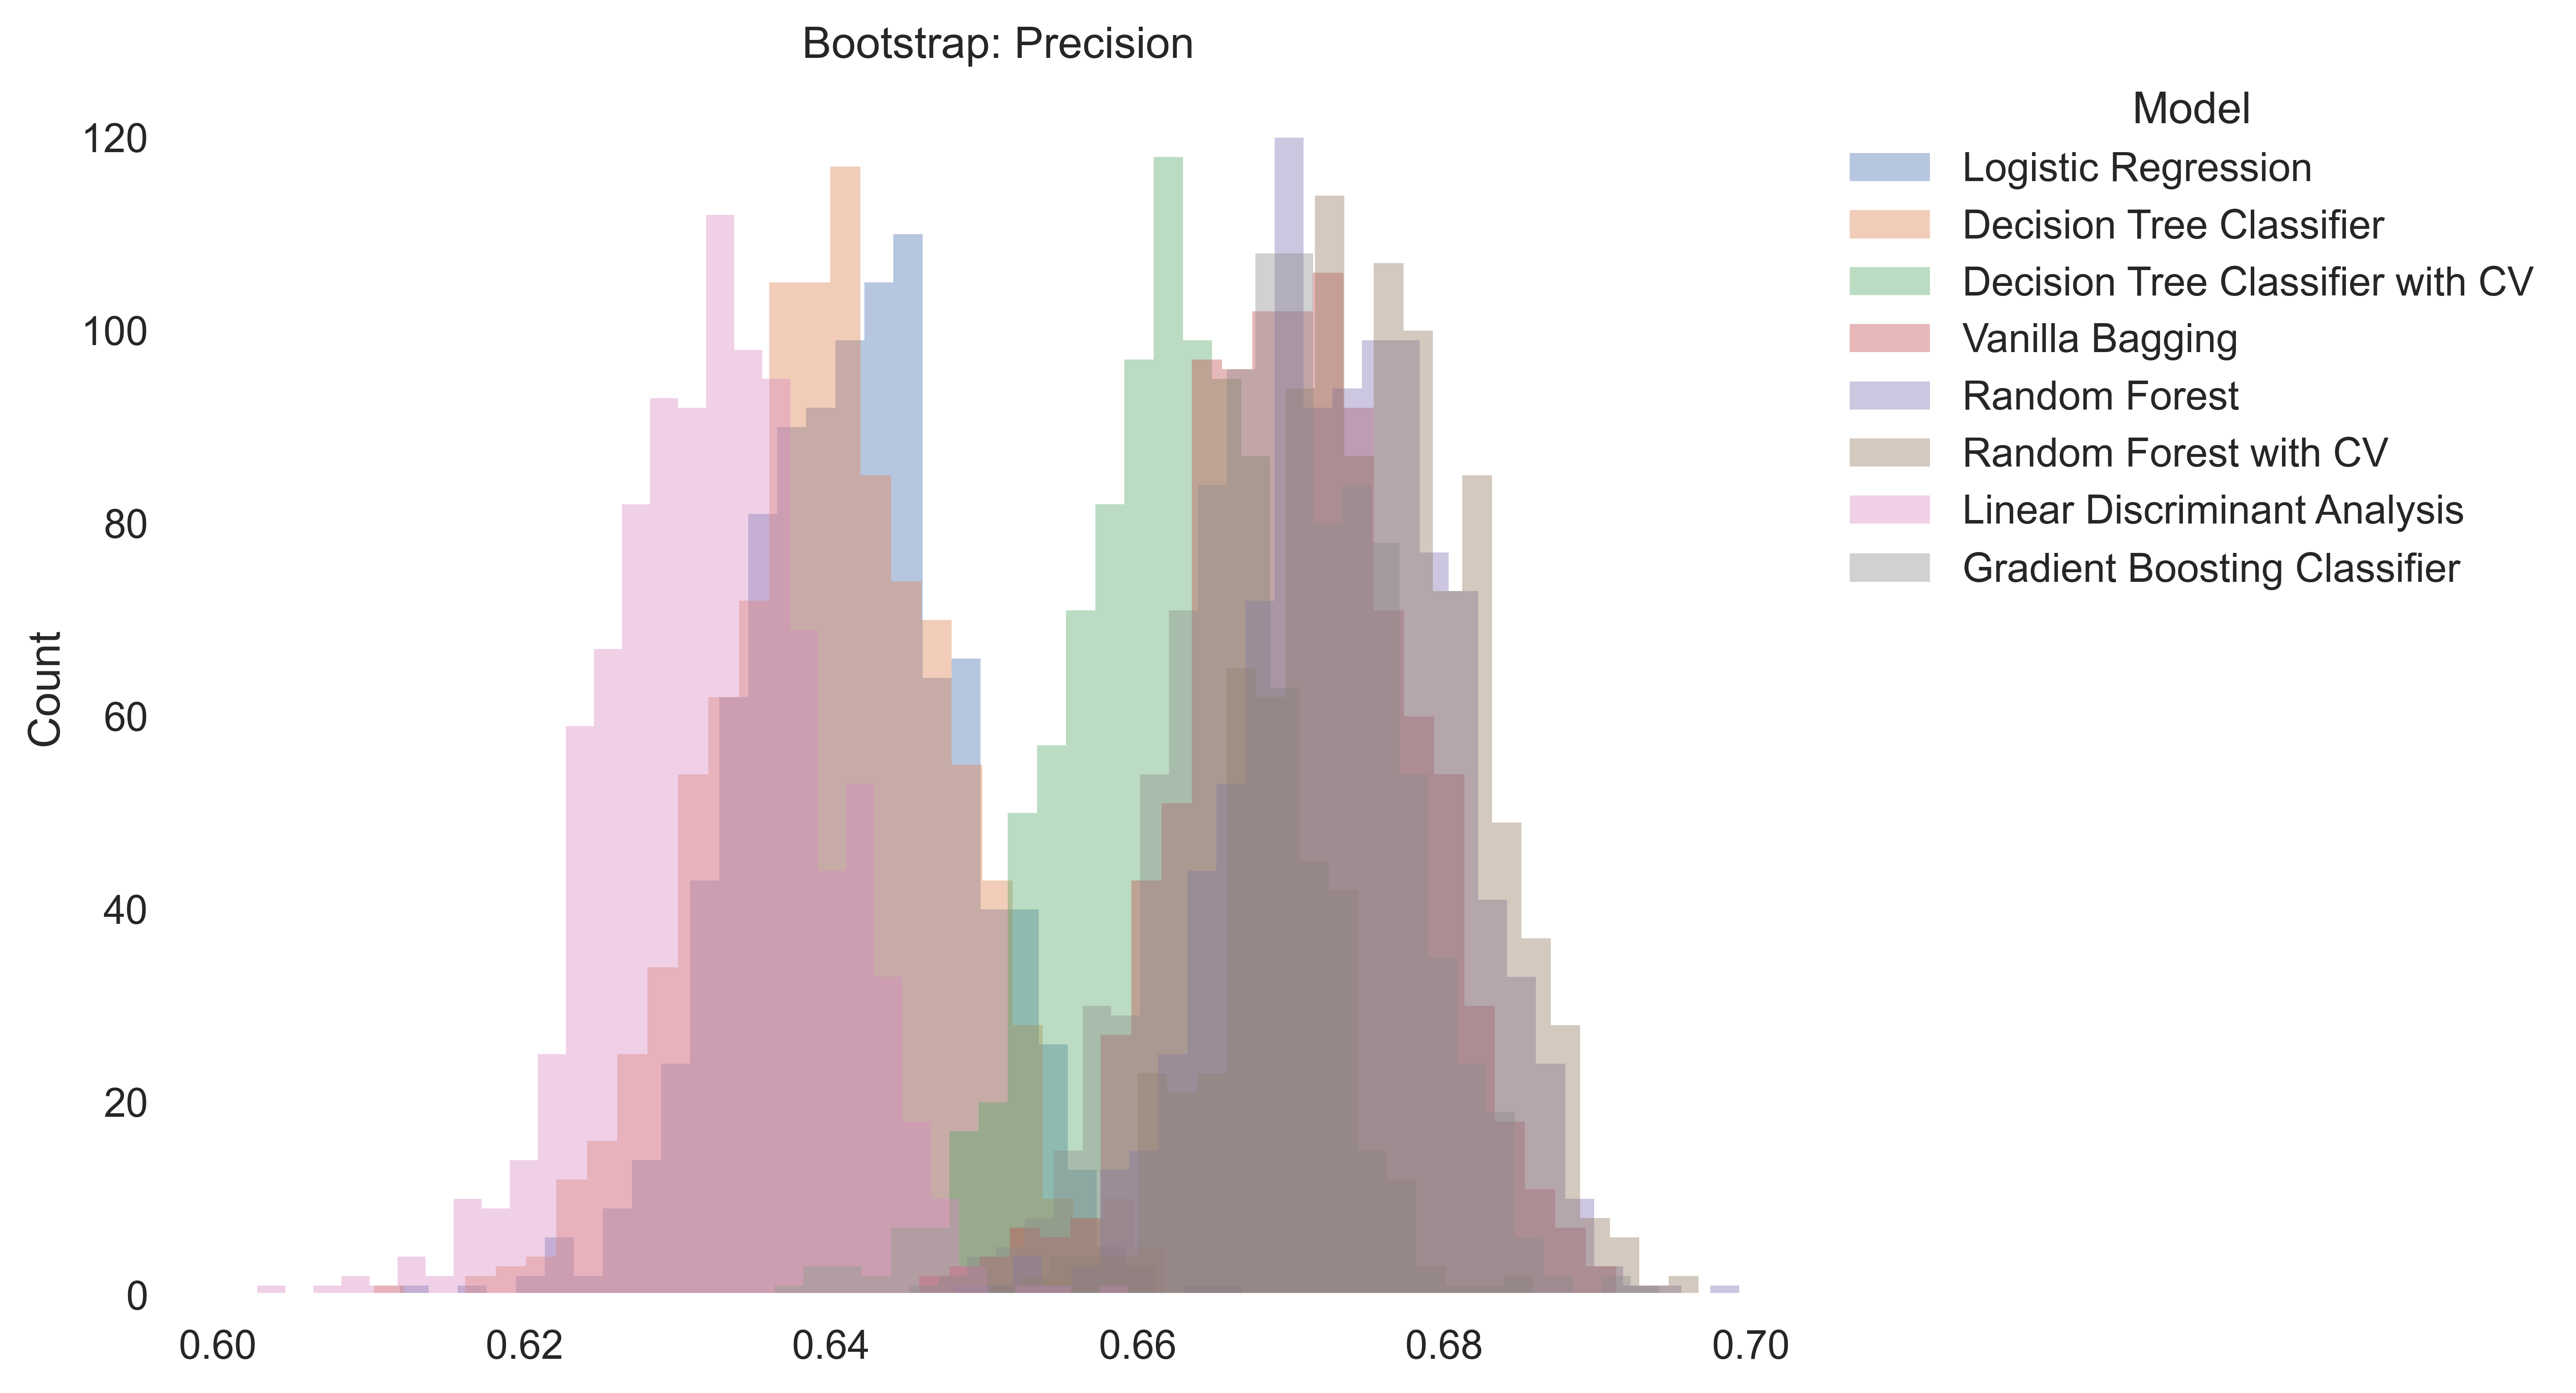

In [26]:
# Bootstrap: Precision
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,3], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: Precision');
plt.legend(title='Model', labels=list(bs.keys()), 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

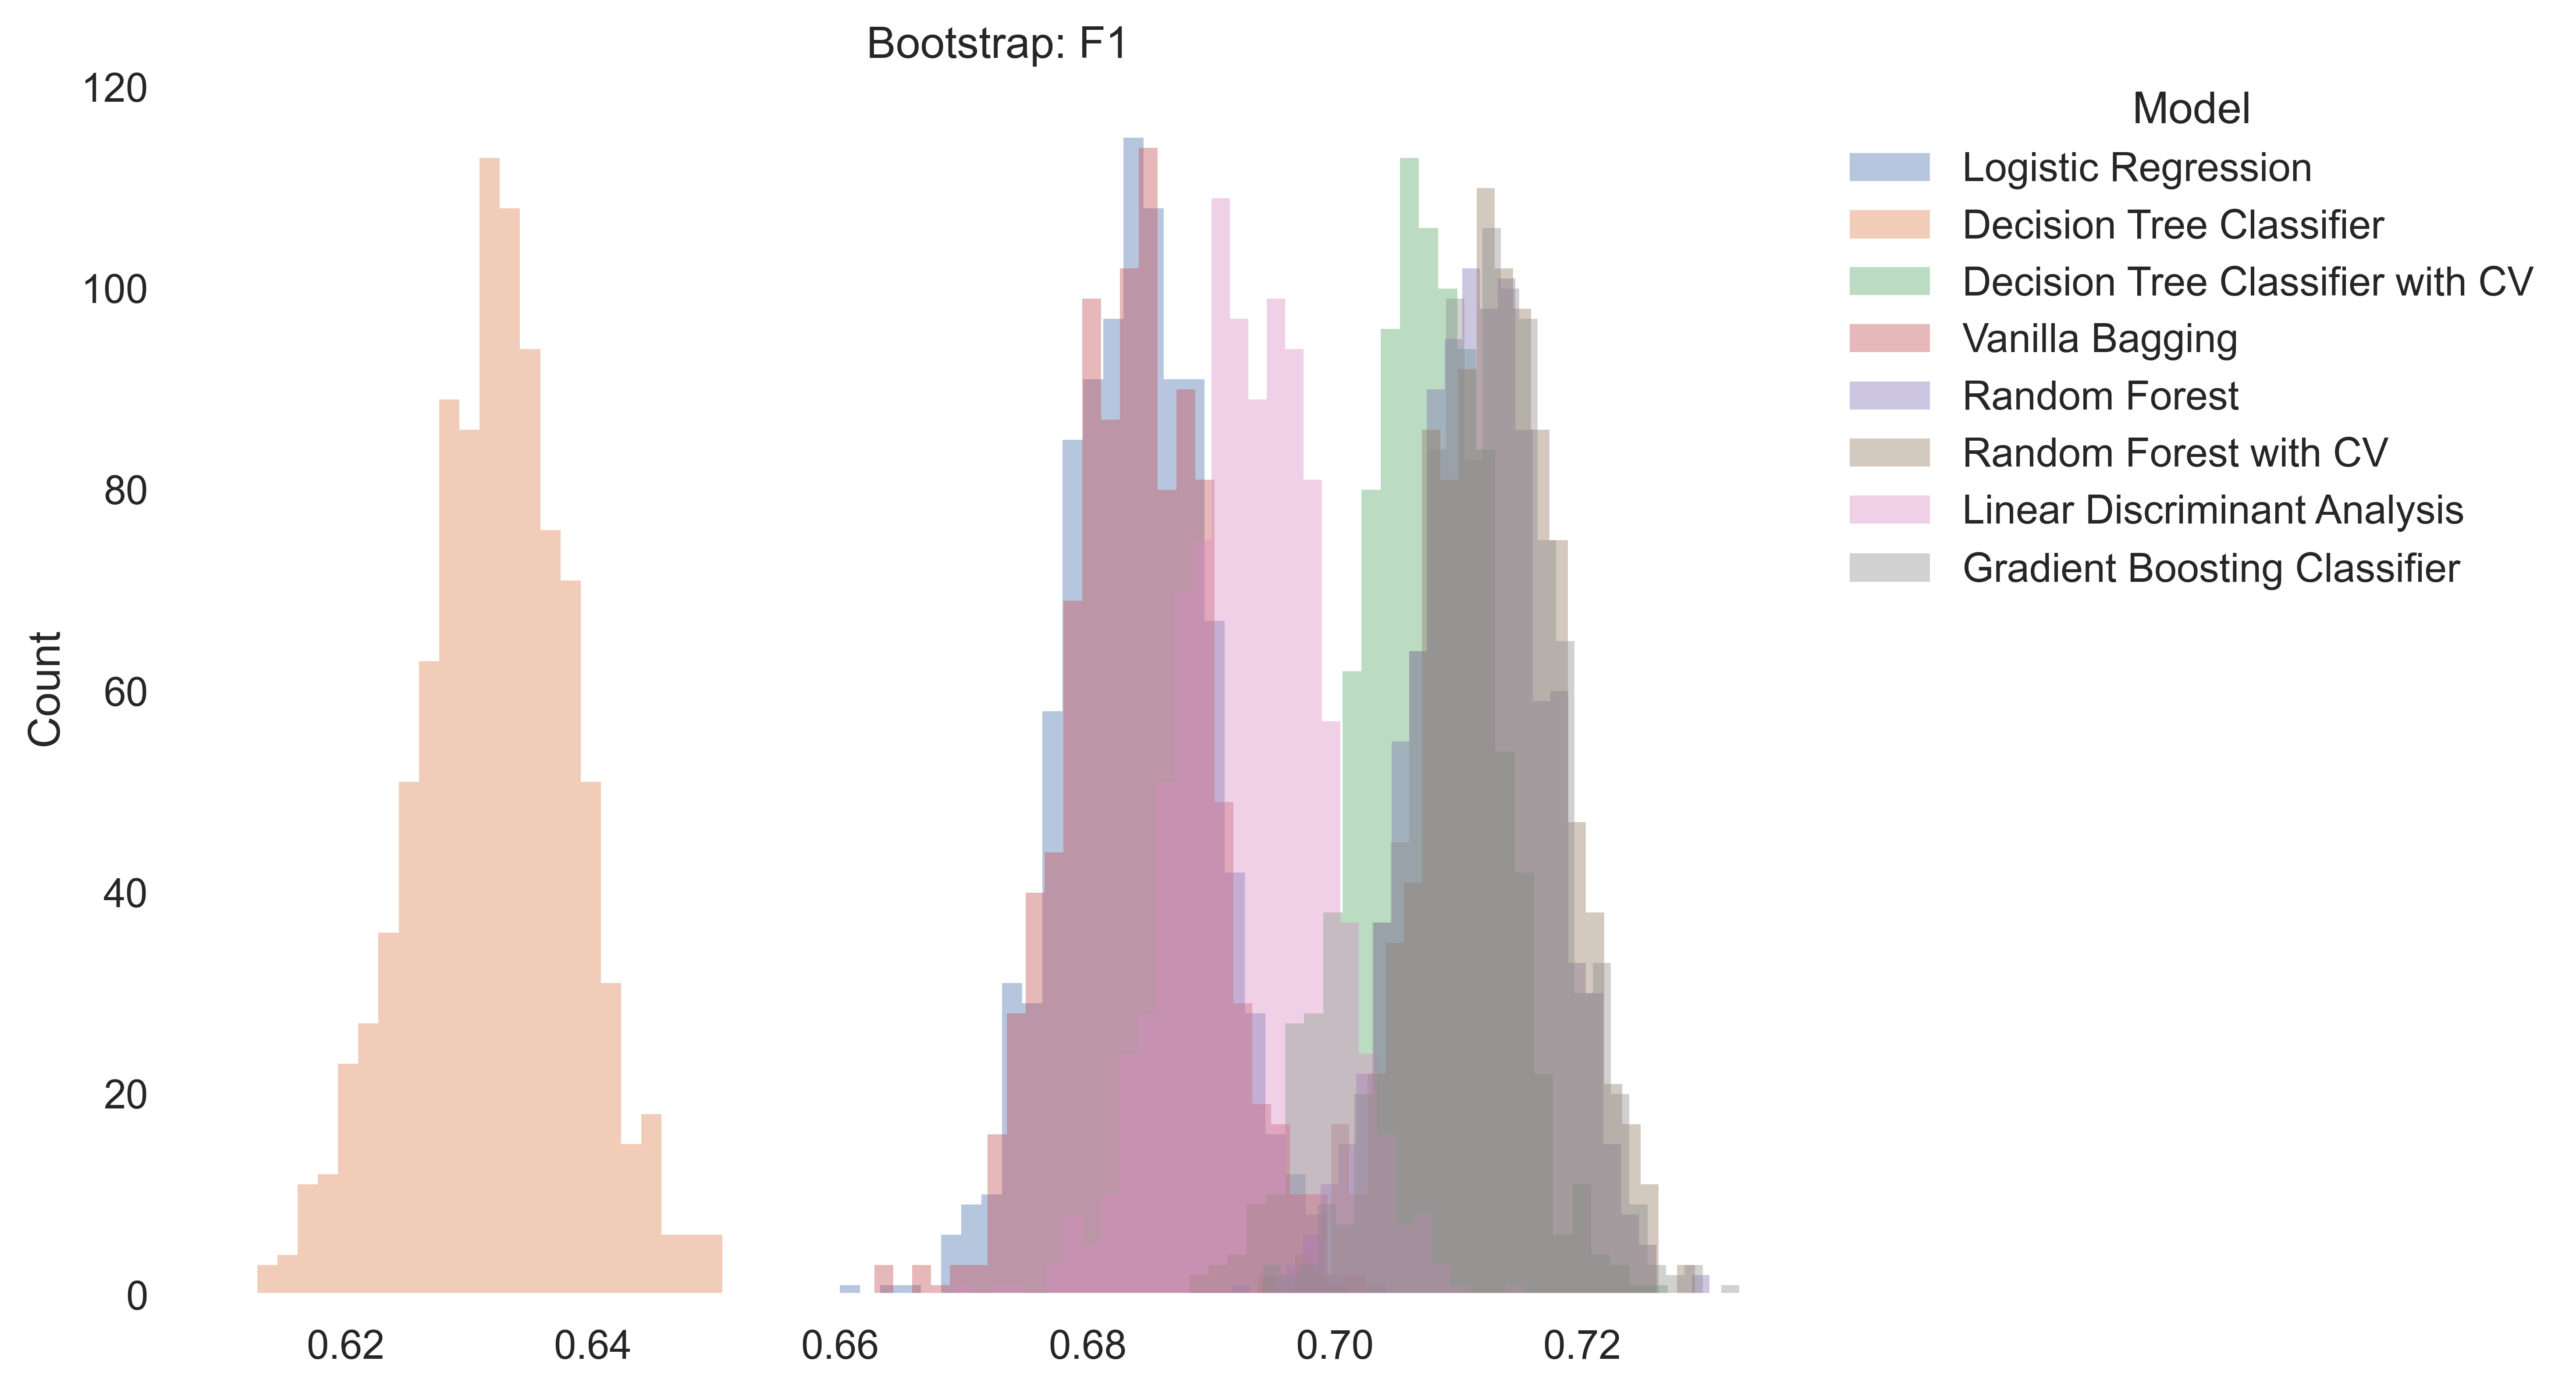

In [27]:
# Bootstrap: F1
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(bs)):
    sns.histplot(np.array(list(bs.values())[i])[:,4], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: F1');
plt.legend(title='Model', labels=list(bs.keys()), 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

# Confidence Interval

In [28]:
metric = ['Accuracy','TPR','FPR','Precision','F1']
for i in range(len(metric)):
    print(f'{metric[i]}')
    df1=pd.DataFrame()
    for m in list(bs.keys()):
        met = np.array(bs[m])[:,i]
        df2 = pd.DataFrame(
                {'model':[m],
                 '95% CI':[np.round(np.quantile(met, np.array([0.025,0.975])), 4)],
                 'mean':[np.mean(met)],
                 'sd':[np.std(met)]
                })
        df1 = pd.concat([df1,df2], ignore_index=True)
    display(df1.sort_values(['mean'], ascending=False))

Accuracy


model            95% CI      mean        sd
5             Random Forest with CV   [0.785, 0.7998]  0.792745  0.003782
4                     Random Forest   [0.784, 0.7992]  0.791783  0.003804
7      Gradient Boosting Classifier  [0.7829, 0.7983]  0.790543  0.003885
2  Decision Tree Classifier with CV   [0.7784, 0.794]  0.785882  0.003923
3                   Vanilla Bagging  [0.7728, 0.7882]  0.780266  0.003865
0               Logistic Regression  [0.7618, 0.7774]  0.769375  0.004089
6      Linear Discriminant Analysis  [0.7609, 0.7766]  0.768657  0.004070
1          Decision Tree Classifier  [0.7438, 0.7602]  0.752277  0.004084

TPR


model            95% CI      mean        sd
6      Linear Discriminant Analysis    [0.7539, 0.78]  0.767274  0.006726
7      Gradient Boosting Classifier  [0.7479, 0.7748]  0.761395  0.006747
2  Decision Tree Classifier with CV  [0.7454, 0.7719]  0.758666  0.006861
5             Random Forest with CV  [0.7419, 0.7678]  0.755067  0.006757
4                     Random Forest  [0.7411, 0.7672]  0.754151  0.006783
0               Logistic Regression  [0.7181, 0.7465]  0.732601  0.007183
3                   Vanilla Bagging   [0.684, 0.7116]  0.698258  0.007228
1          Decision Tree Classifier   [0.609, 0.6394]  0.624392  0.007667

FPR


model            95% CI      mean        sd
6      Linear Discriminant Analysis   [0.221, 0.2403]  0.230626  0.004888
0               Logistic Regression  [0.2022, 0.2207]  0.211611  0.004775
2  Decision Tree Classifier with CV  [0.1913, 0.2092]  0.200045  0.004621
7      Gradient Boosting Classifier  [0.1851, 0.2035]  0.194386  0.004671
4                     Random Forest  [0.1798, 0.1977]  0.188758  0.004559
5             Random Forest with CV  [0.1792, 0.1965]  0.187772  0.004525
1          Decision Tree Classifier   [0.173, 0.1906]  0.181603  0.004380
3                   Vanilla Bagging  [0.1685, 0.1861]  0.177333  0.004442

Precision


model            95% CI      mean        sd
5             Random Forest with CV  [0.6613, 0.6879]  0.675234  0.007039
4                     Random Forest   [0.6596, 0.687]  0.673817  0.007026
3                   Vanilla Bagging  [0.6569, 0.6848]  0.670608  0.007281
7      Gradient Boosting Classifier  [0.6557, 0.6836]  0.669446  0.007142
2  Decision Tree Classifier with CV  [0.6485, 0.6751]  0.662260  0.007125
0               Logistic Regression  [0.6277, 0.6549]  0.641579  0.007185
1          Decision Tree Classifier  [0.6244, 0.6551]  0.639989  0.007734
6      Linear Discriminant Analysis  [0.6184, 0.6456]  0.632373  0.007029

F1


model            95% CI      mean        sd
5             Random Forest with CV  [0.7013, 0.7236]  0.712897  0.005519
7      Gradient Boosting Classifier   [0.7018, 0.723]  0.712441  0.005629
4                     Random Forest   [0.7007, 0.722]  0.711699  0.005505
2  Decision Tree Classifier with CV  [0.6958, 0.7177]  0.707168  0.005732
6      Linear Discriminant Analysis  [0.6822, 0.7042]  0.693299  0.005723
3                   Vanilla Bagging   [0.6729, 0.696]  0.684127  0.005849
0               Logistic Regression  [0.6726, 0.6957]  0.684050  0.005893
1          Decision Tree Classifier  [0.6189, 0.6448]  0.632066  0.006446

# Best Models Based on Precision and TPR

In [29]:
best = ['Decision Tree Classifier with CV',
        'Random Forest',
        'Random Forest with CV',
        'Gradient Boosting Classifier']

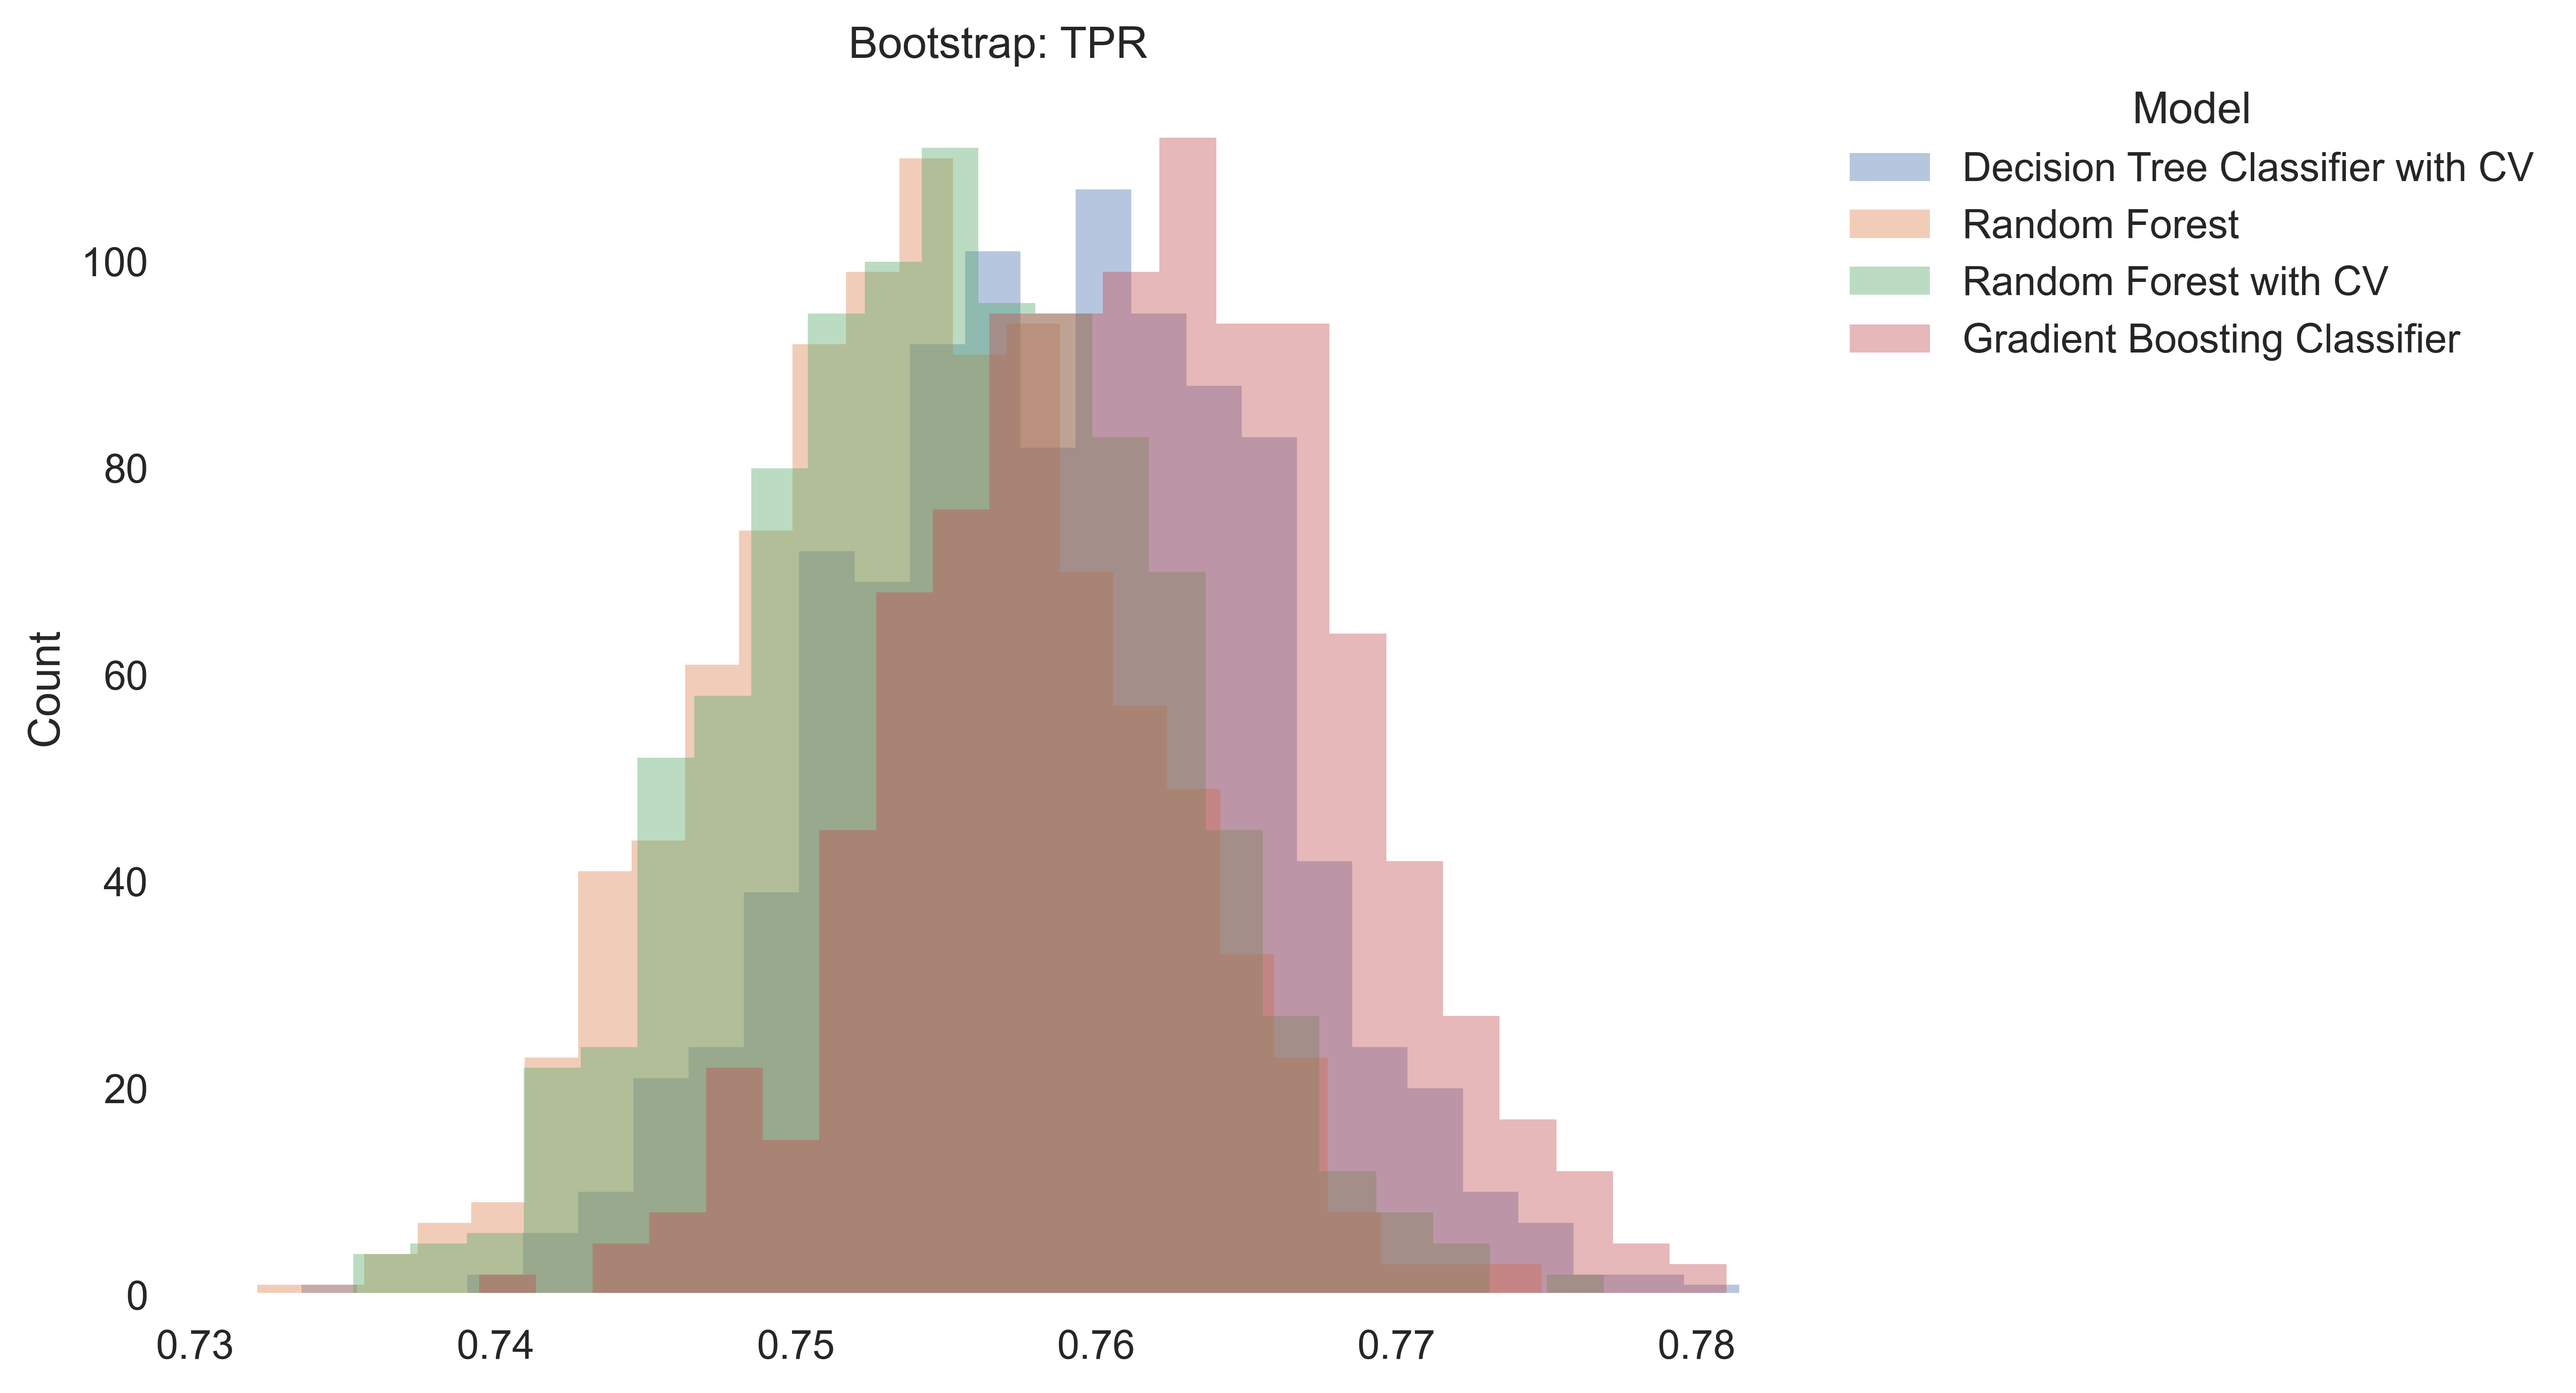

In [30]:
# Bootstrap: TPR
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(best)):
    sns.histplot(np.array(bs[best[i]])[:,1], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: TPR');
plt.legend(title='Model', labels=best, 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

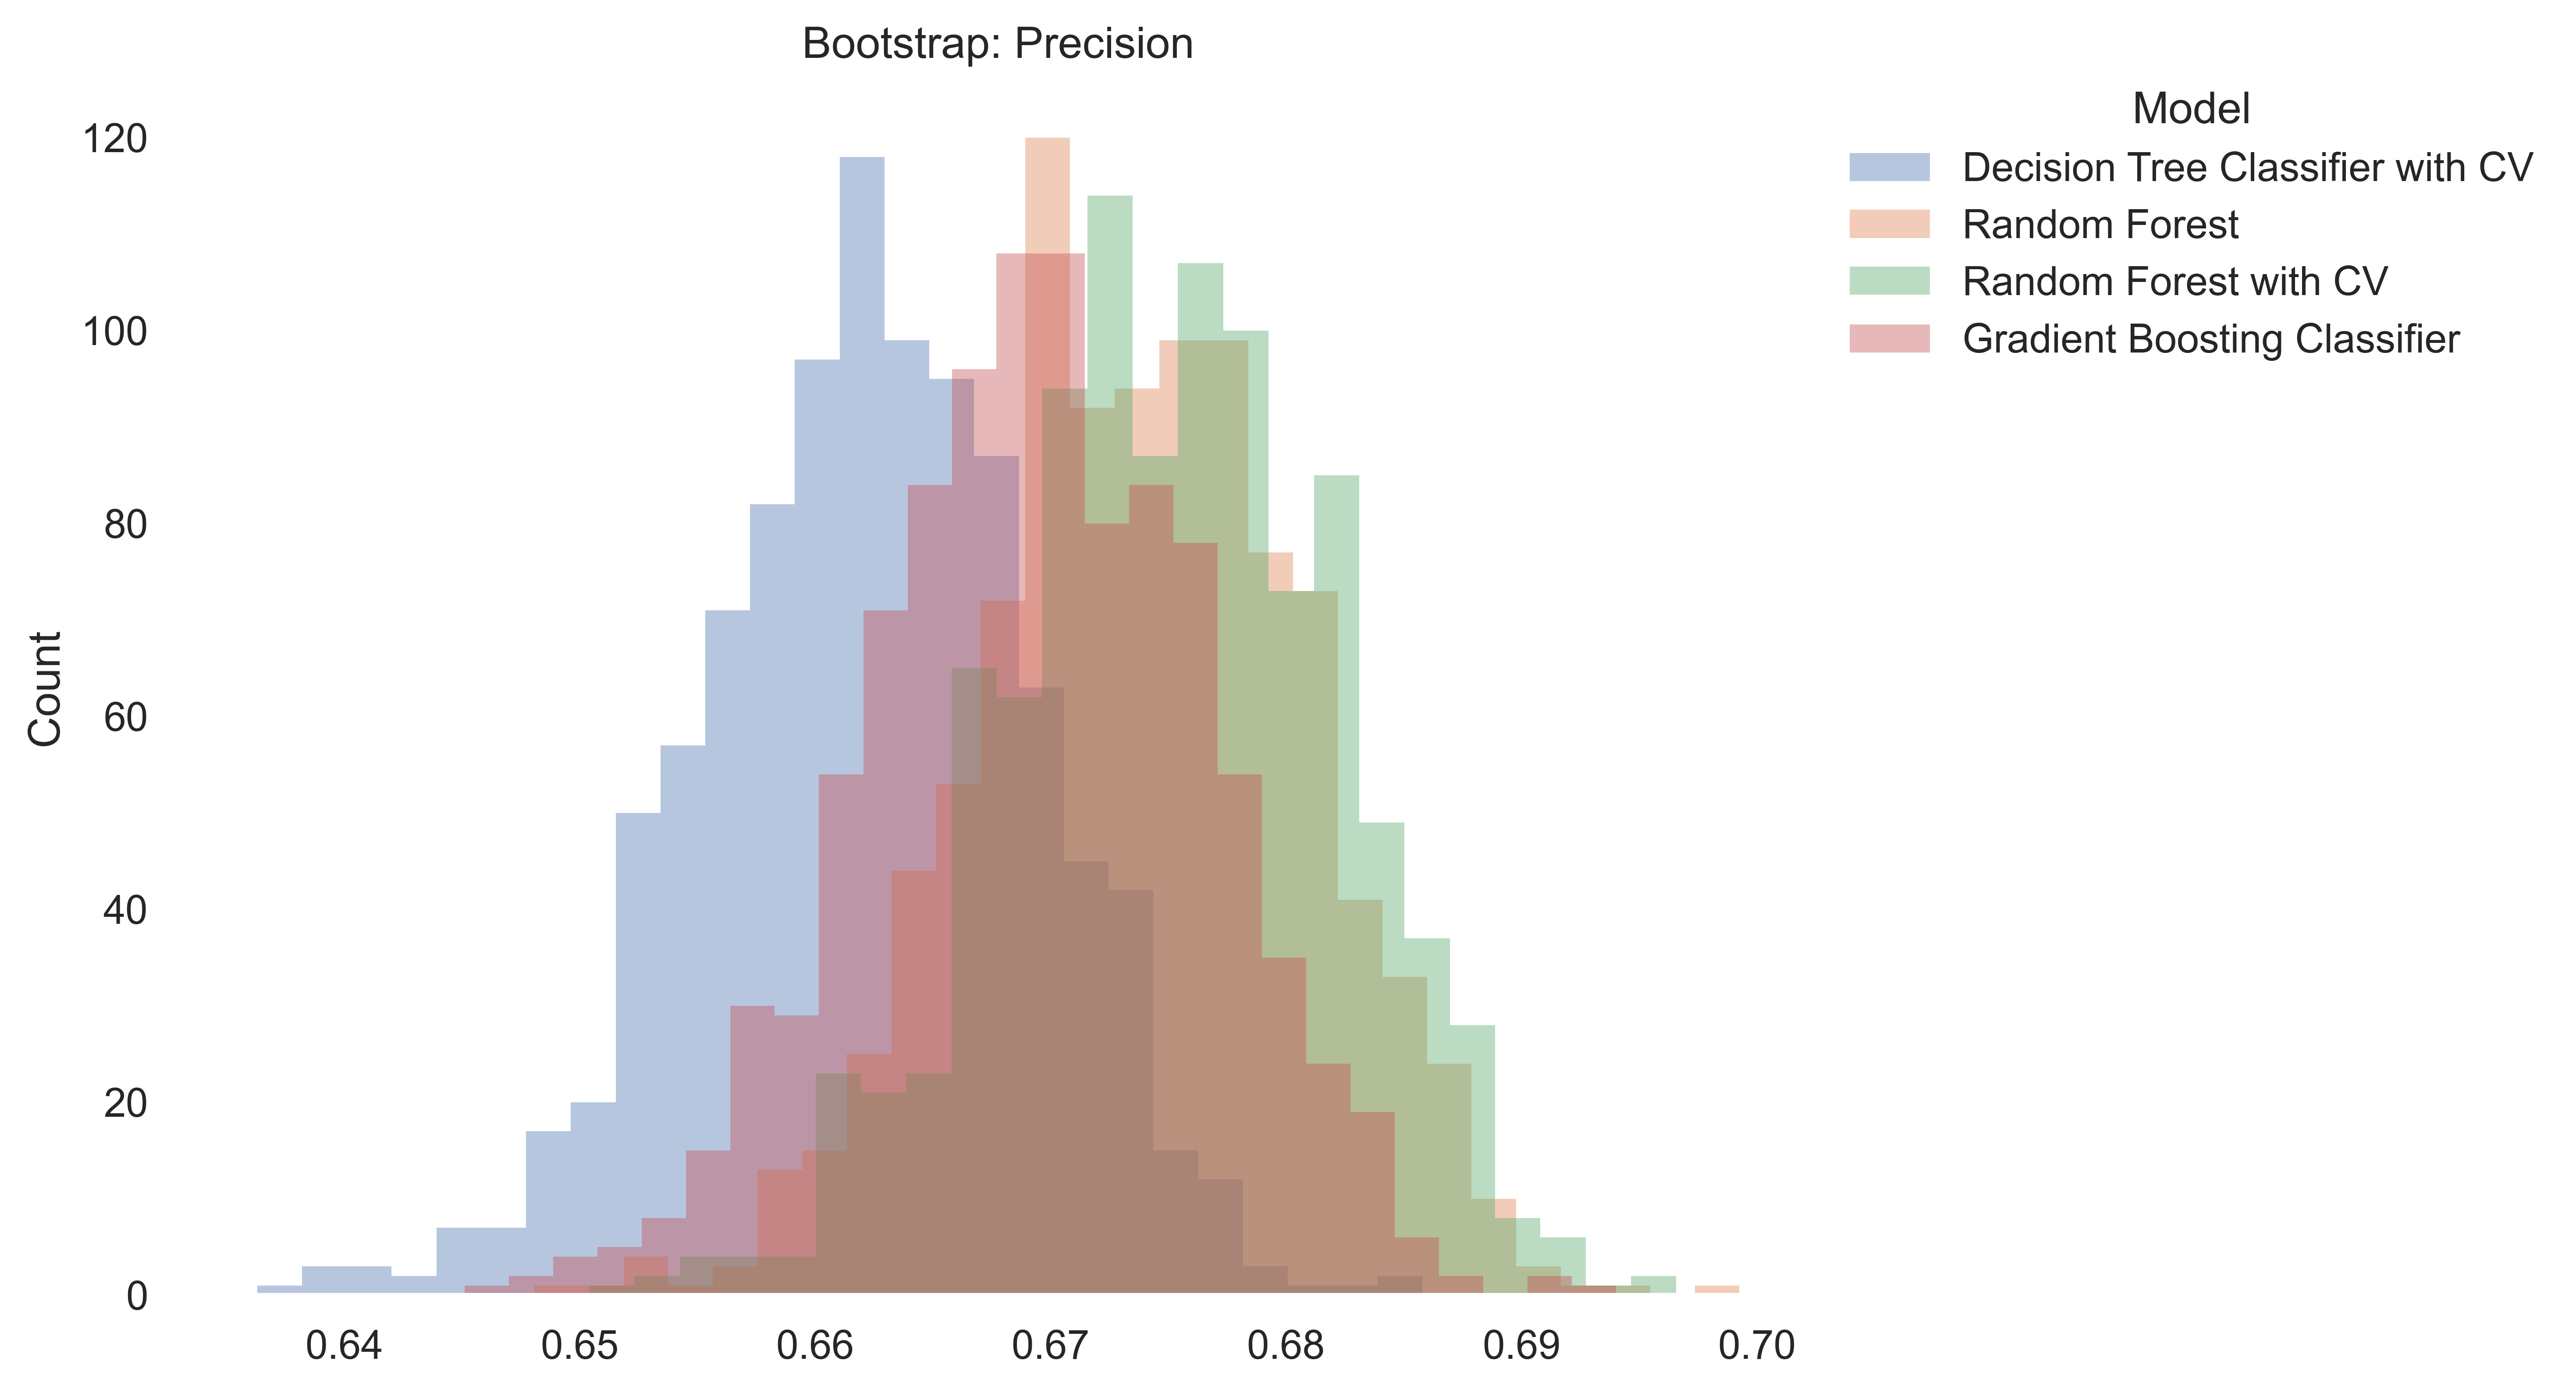

In [31]:
# Bootstrap: Precision
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(best)):
    sns.histplot(np.array(bs[best[i]])[:,3], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Bootstrap: Precision');
plt.legend(title='Model', labels=best, 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

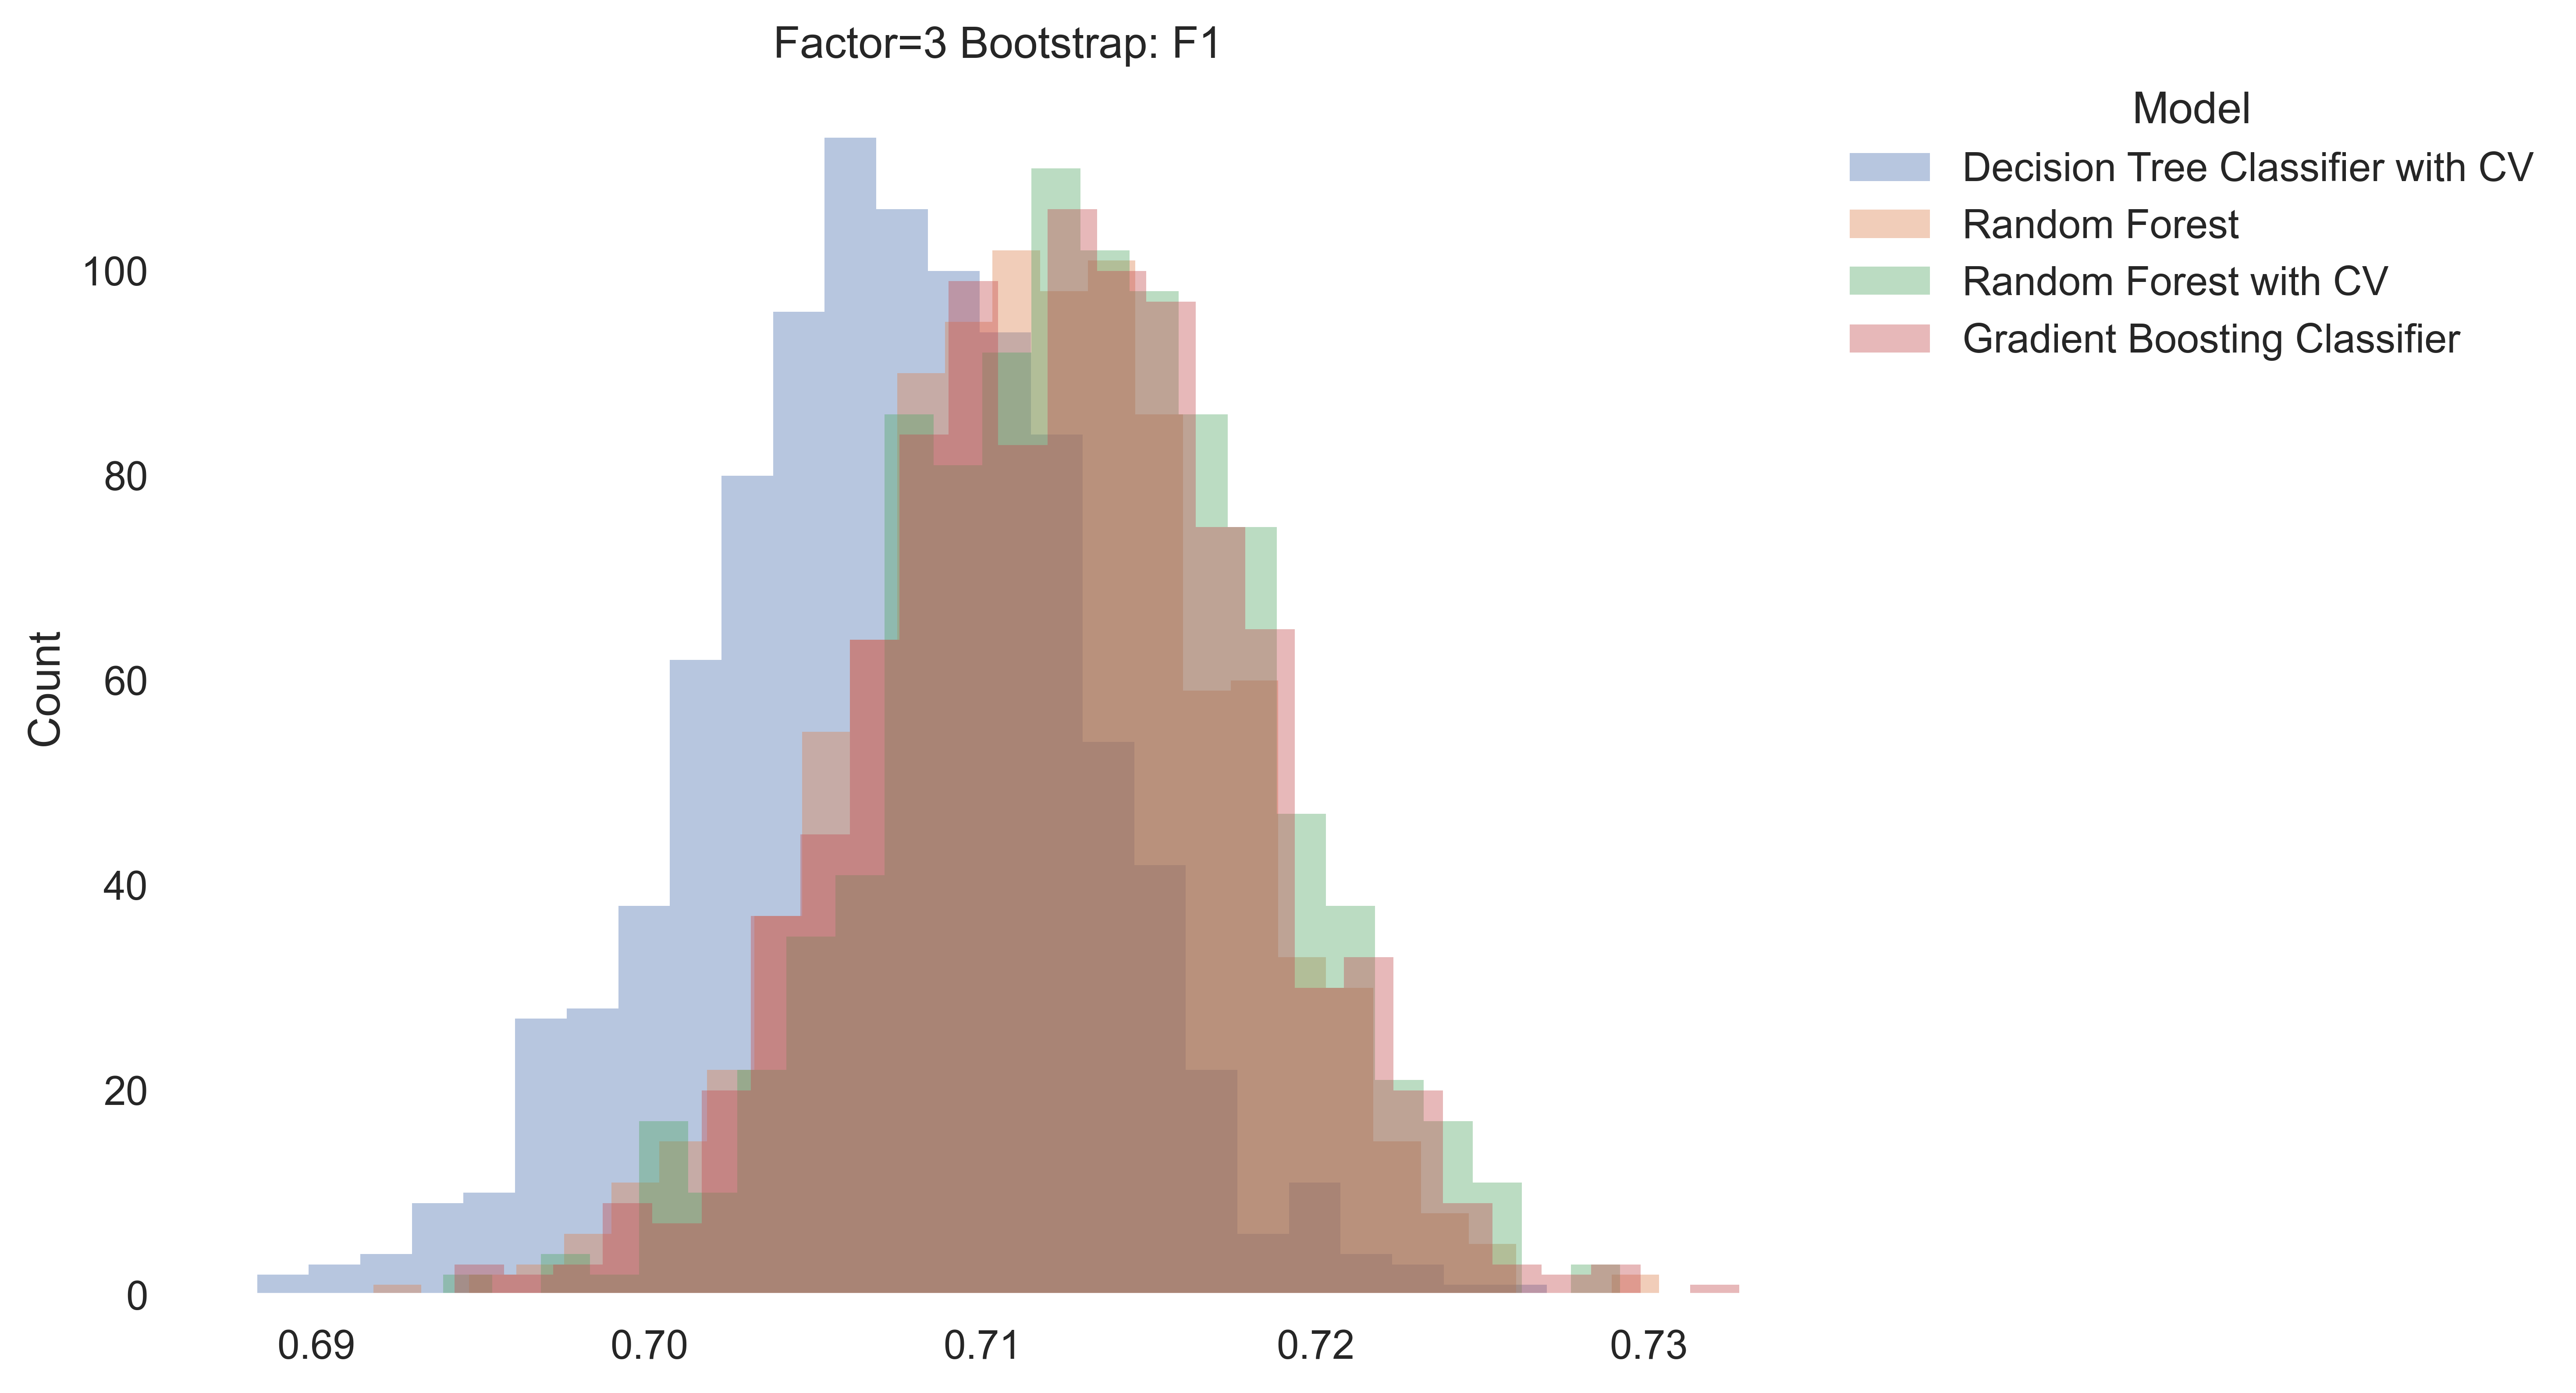

In [32]:
# Bootstrap: F1
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(len(best)):
    sns.histplot(np.array(bs[best[i]])[:,4], edgecolor='none', 
                 color=sns.color_palette()[i], alpha=0.4, ax=ax);
plt.title('Factor=3 Bootstrap: F1');
plt.legend(title='Model', labels=best, 
           bbox_to_anchor=(1, 1.02), loc="upper left");
plt.grid(False);
ax.set_facecolor('white');

# ROC and Precision-Recall

In [33]:
models = {
          'Decision Tree Classifier with CV':dtc_cv,
          'Random Forest':rf,
          'Random Forest with CV':rf_cv,
          'Gradient Boosting Classifier':gbc,
          }

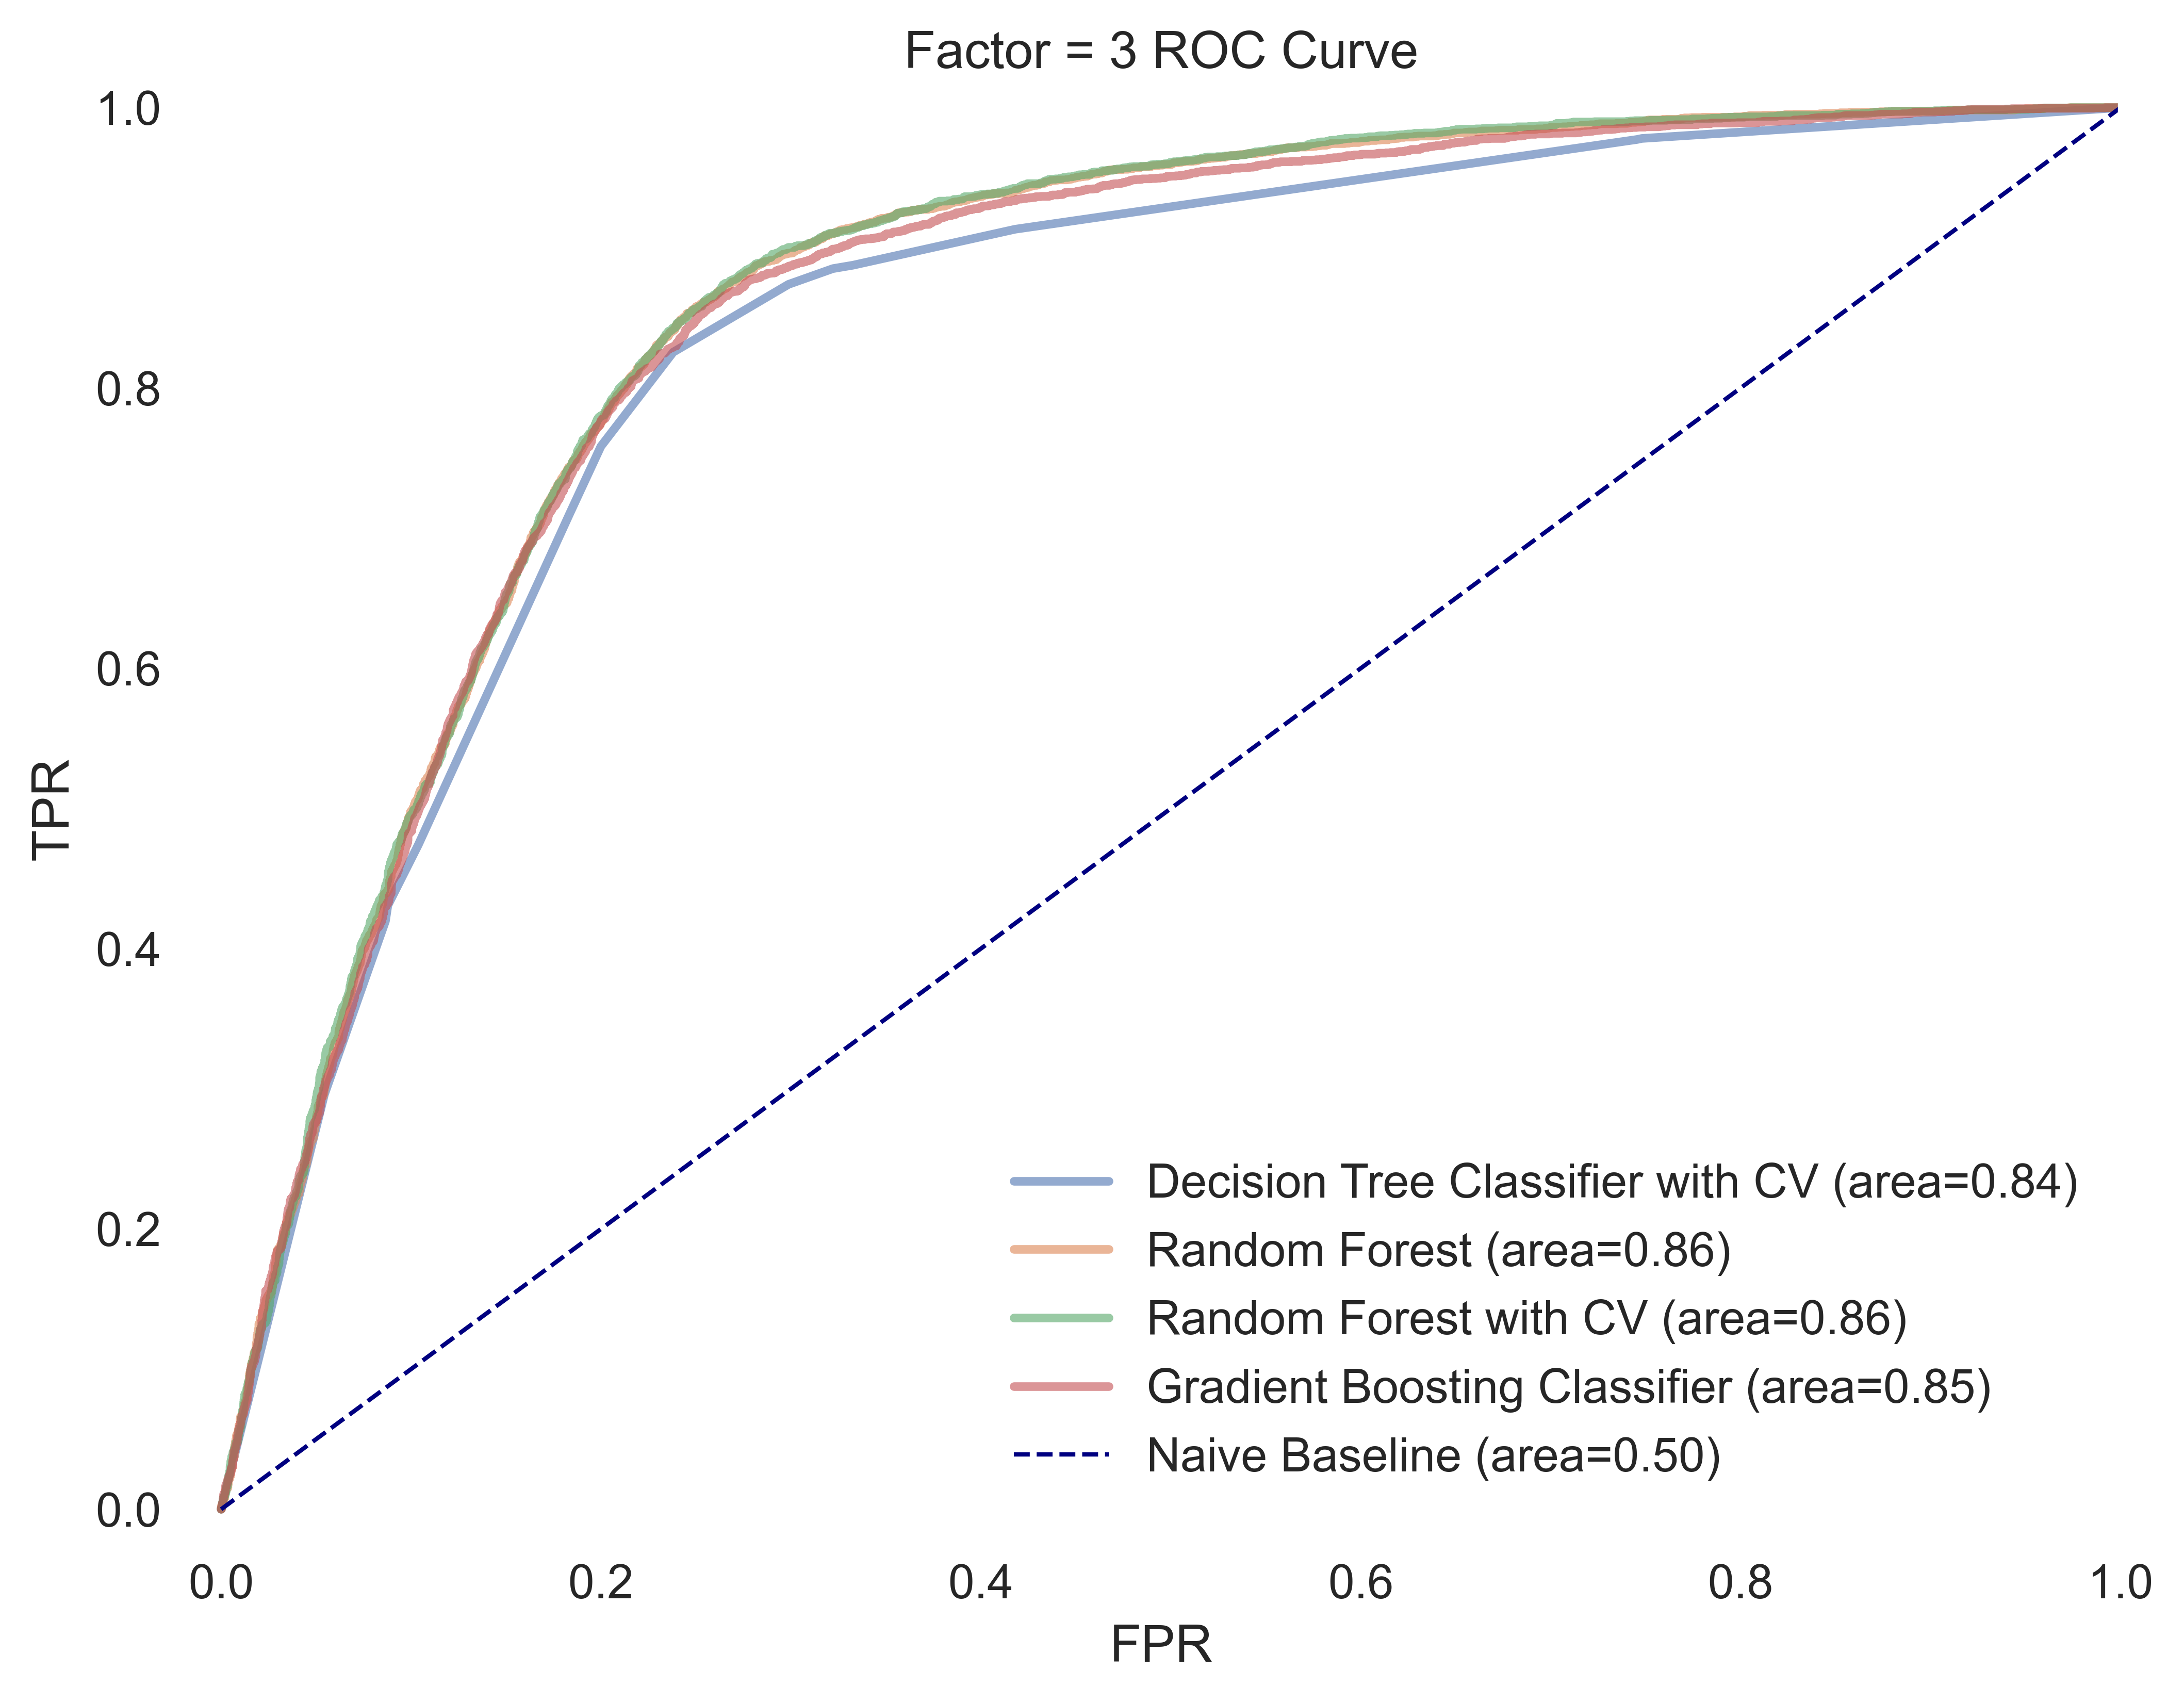

In [34]:
plt.rcParams['axes.facecolor']='white'
fig, ax = plt.subplots(nrows=1, ncols=1)
for m in range(len(models)):
    y_prob = list(models.values())[m].predict_proba(X_test)[:,1]
    y_pred = list(models.values())[m].predict(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.6,
            label=f'{list(models.keys())[m]} (area={roc_auc:0.2f})')
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', 
             label='Naive Baseline (area=0.50)')
ax.legend(loc='lower right')
plt.title('Factor = 3 ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.show()

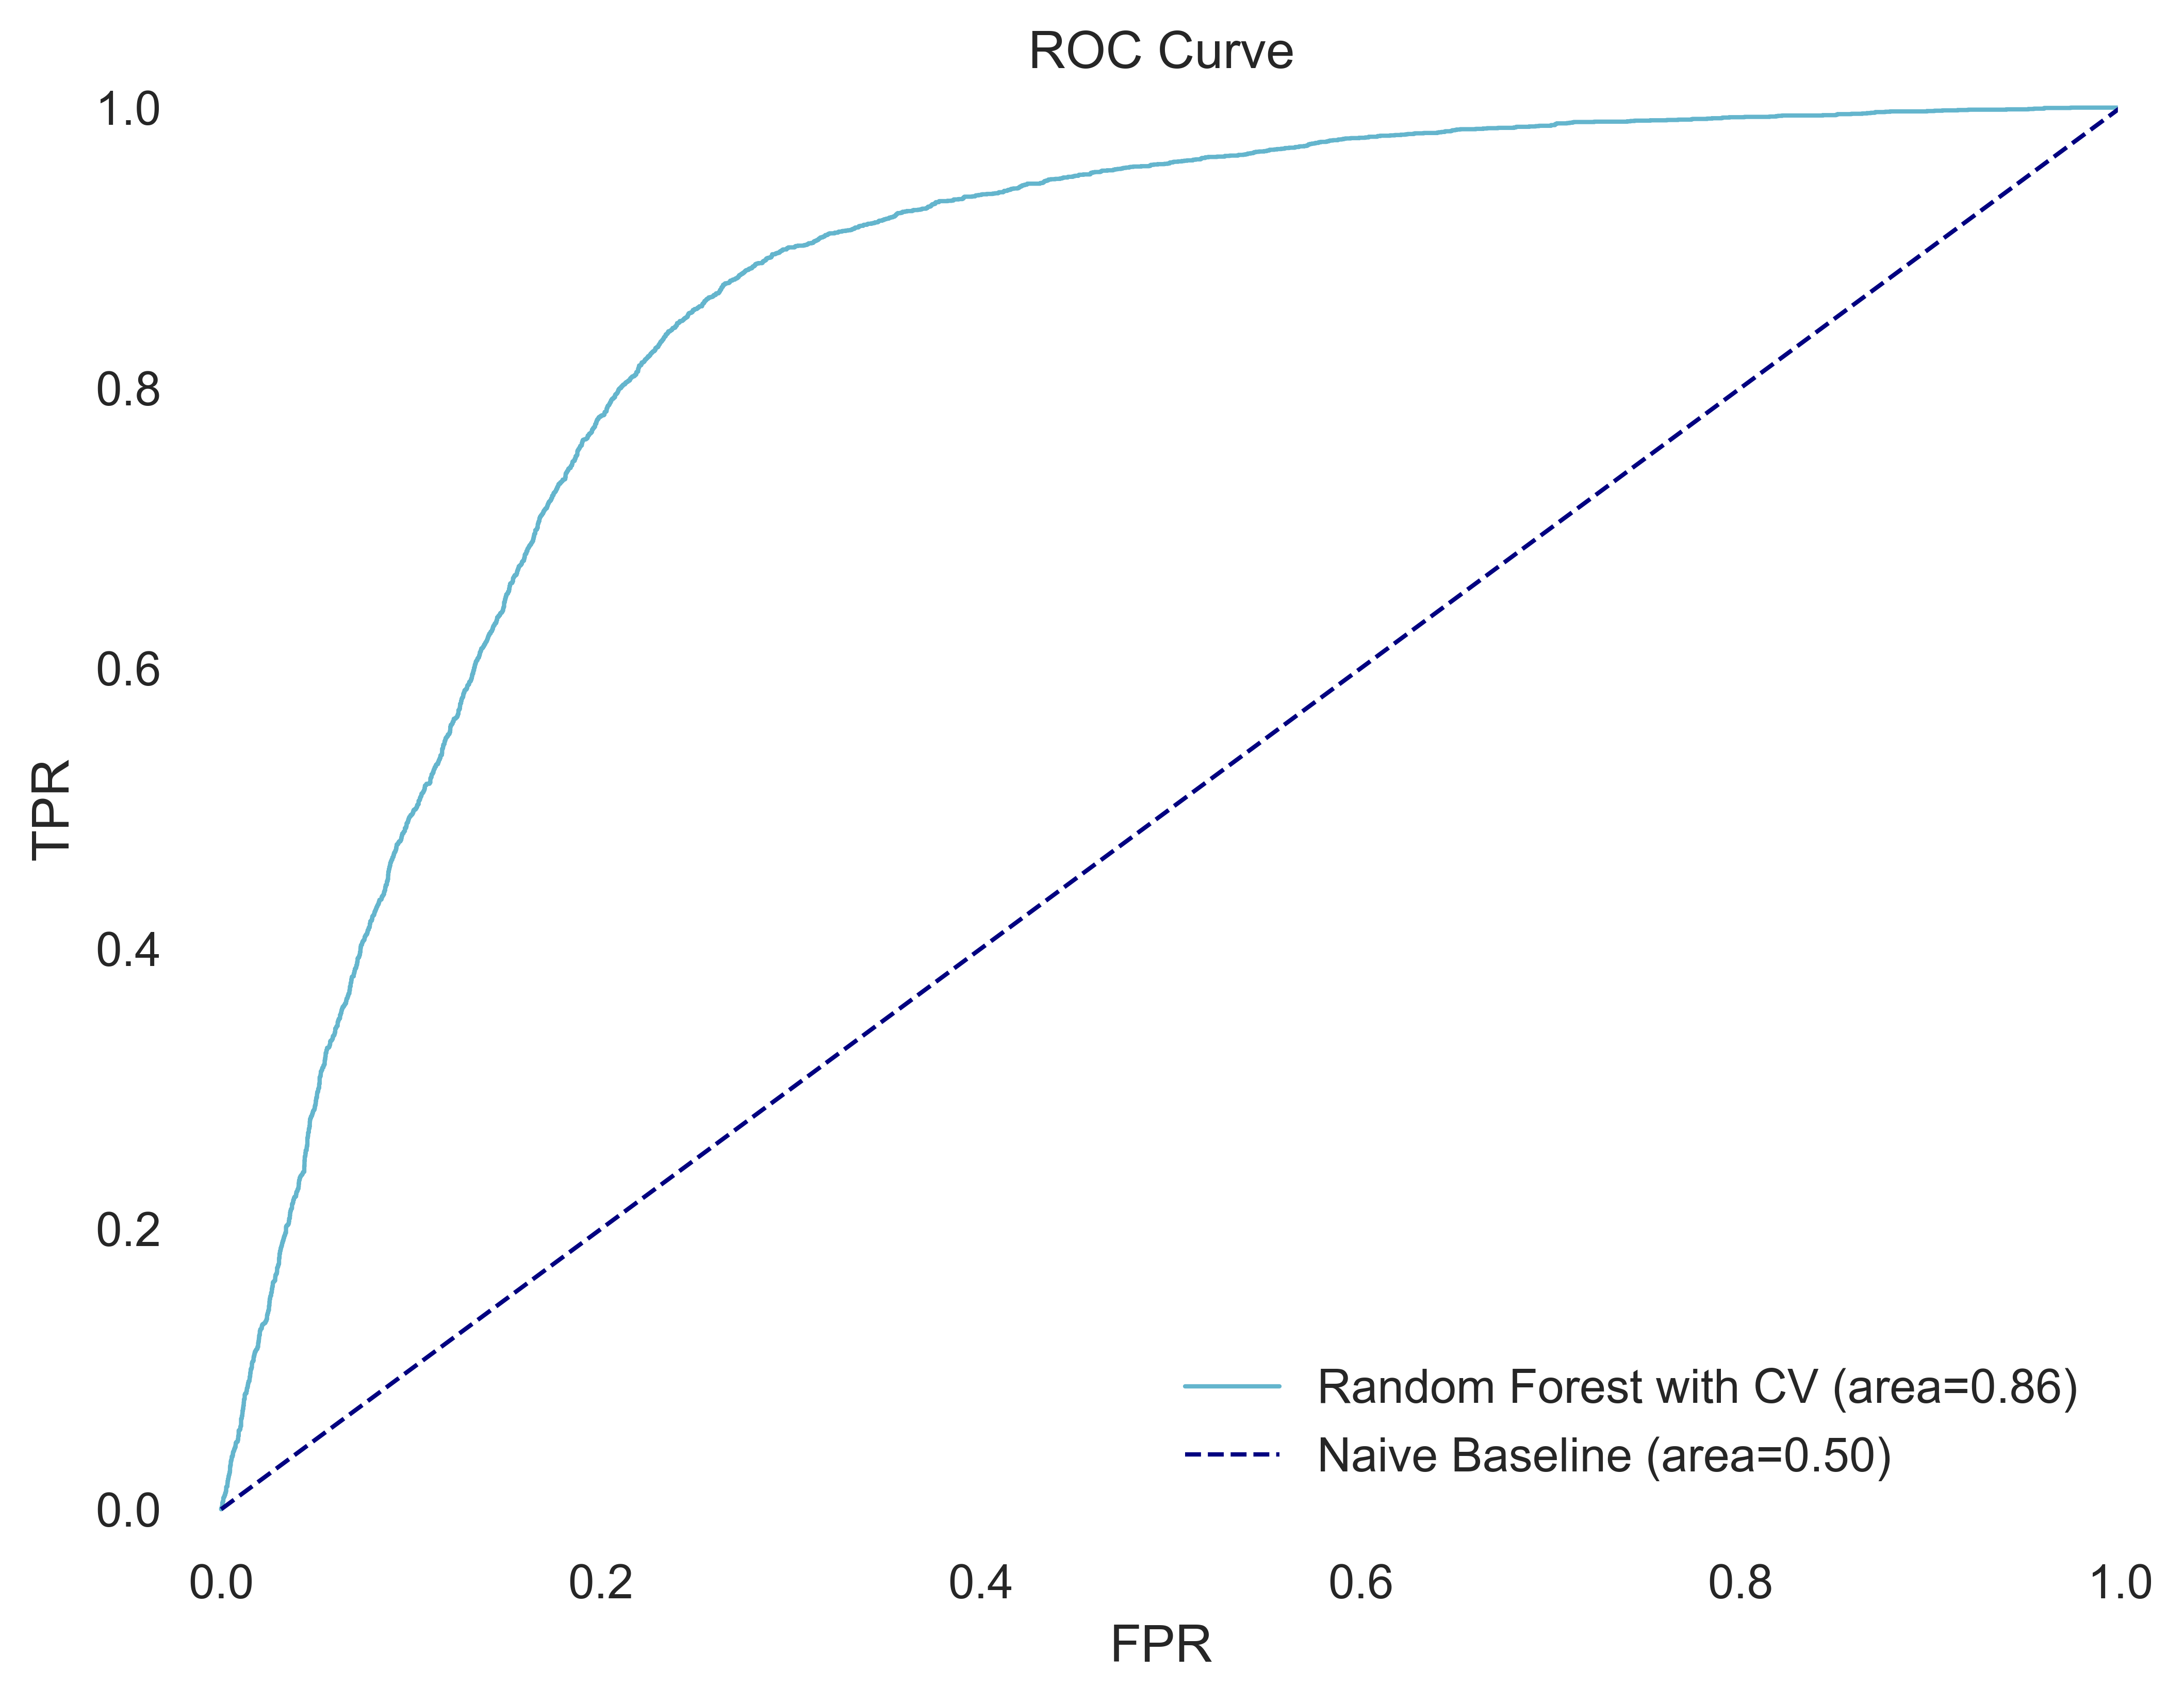

In [35]:
y_prob = rf_cv.predict_proba(X_test)[:,1]
y_pred = rf_cv.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, lw=1, color='c', 
         label=f'Random Forest with CV (area={roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', 
         label='Naive Baseline (area=0.50)')
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.show()

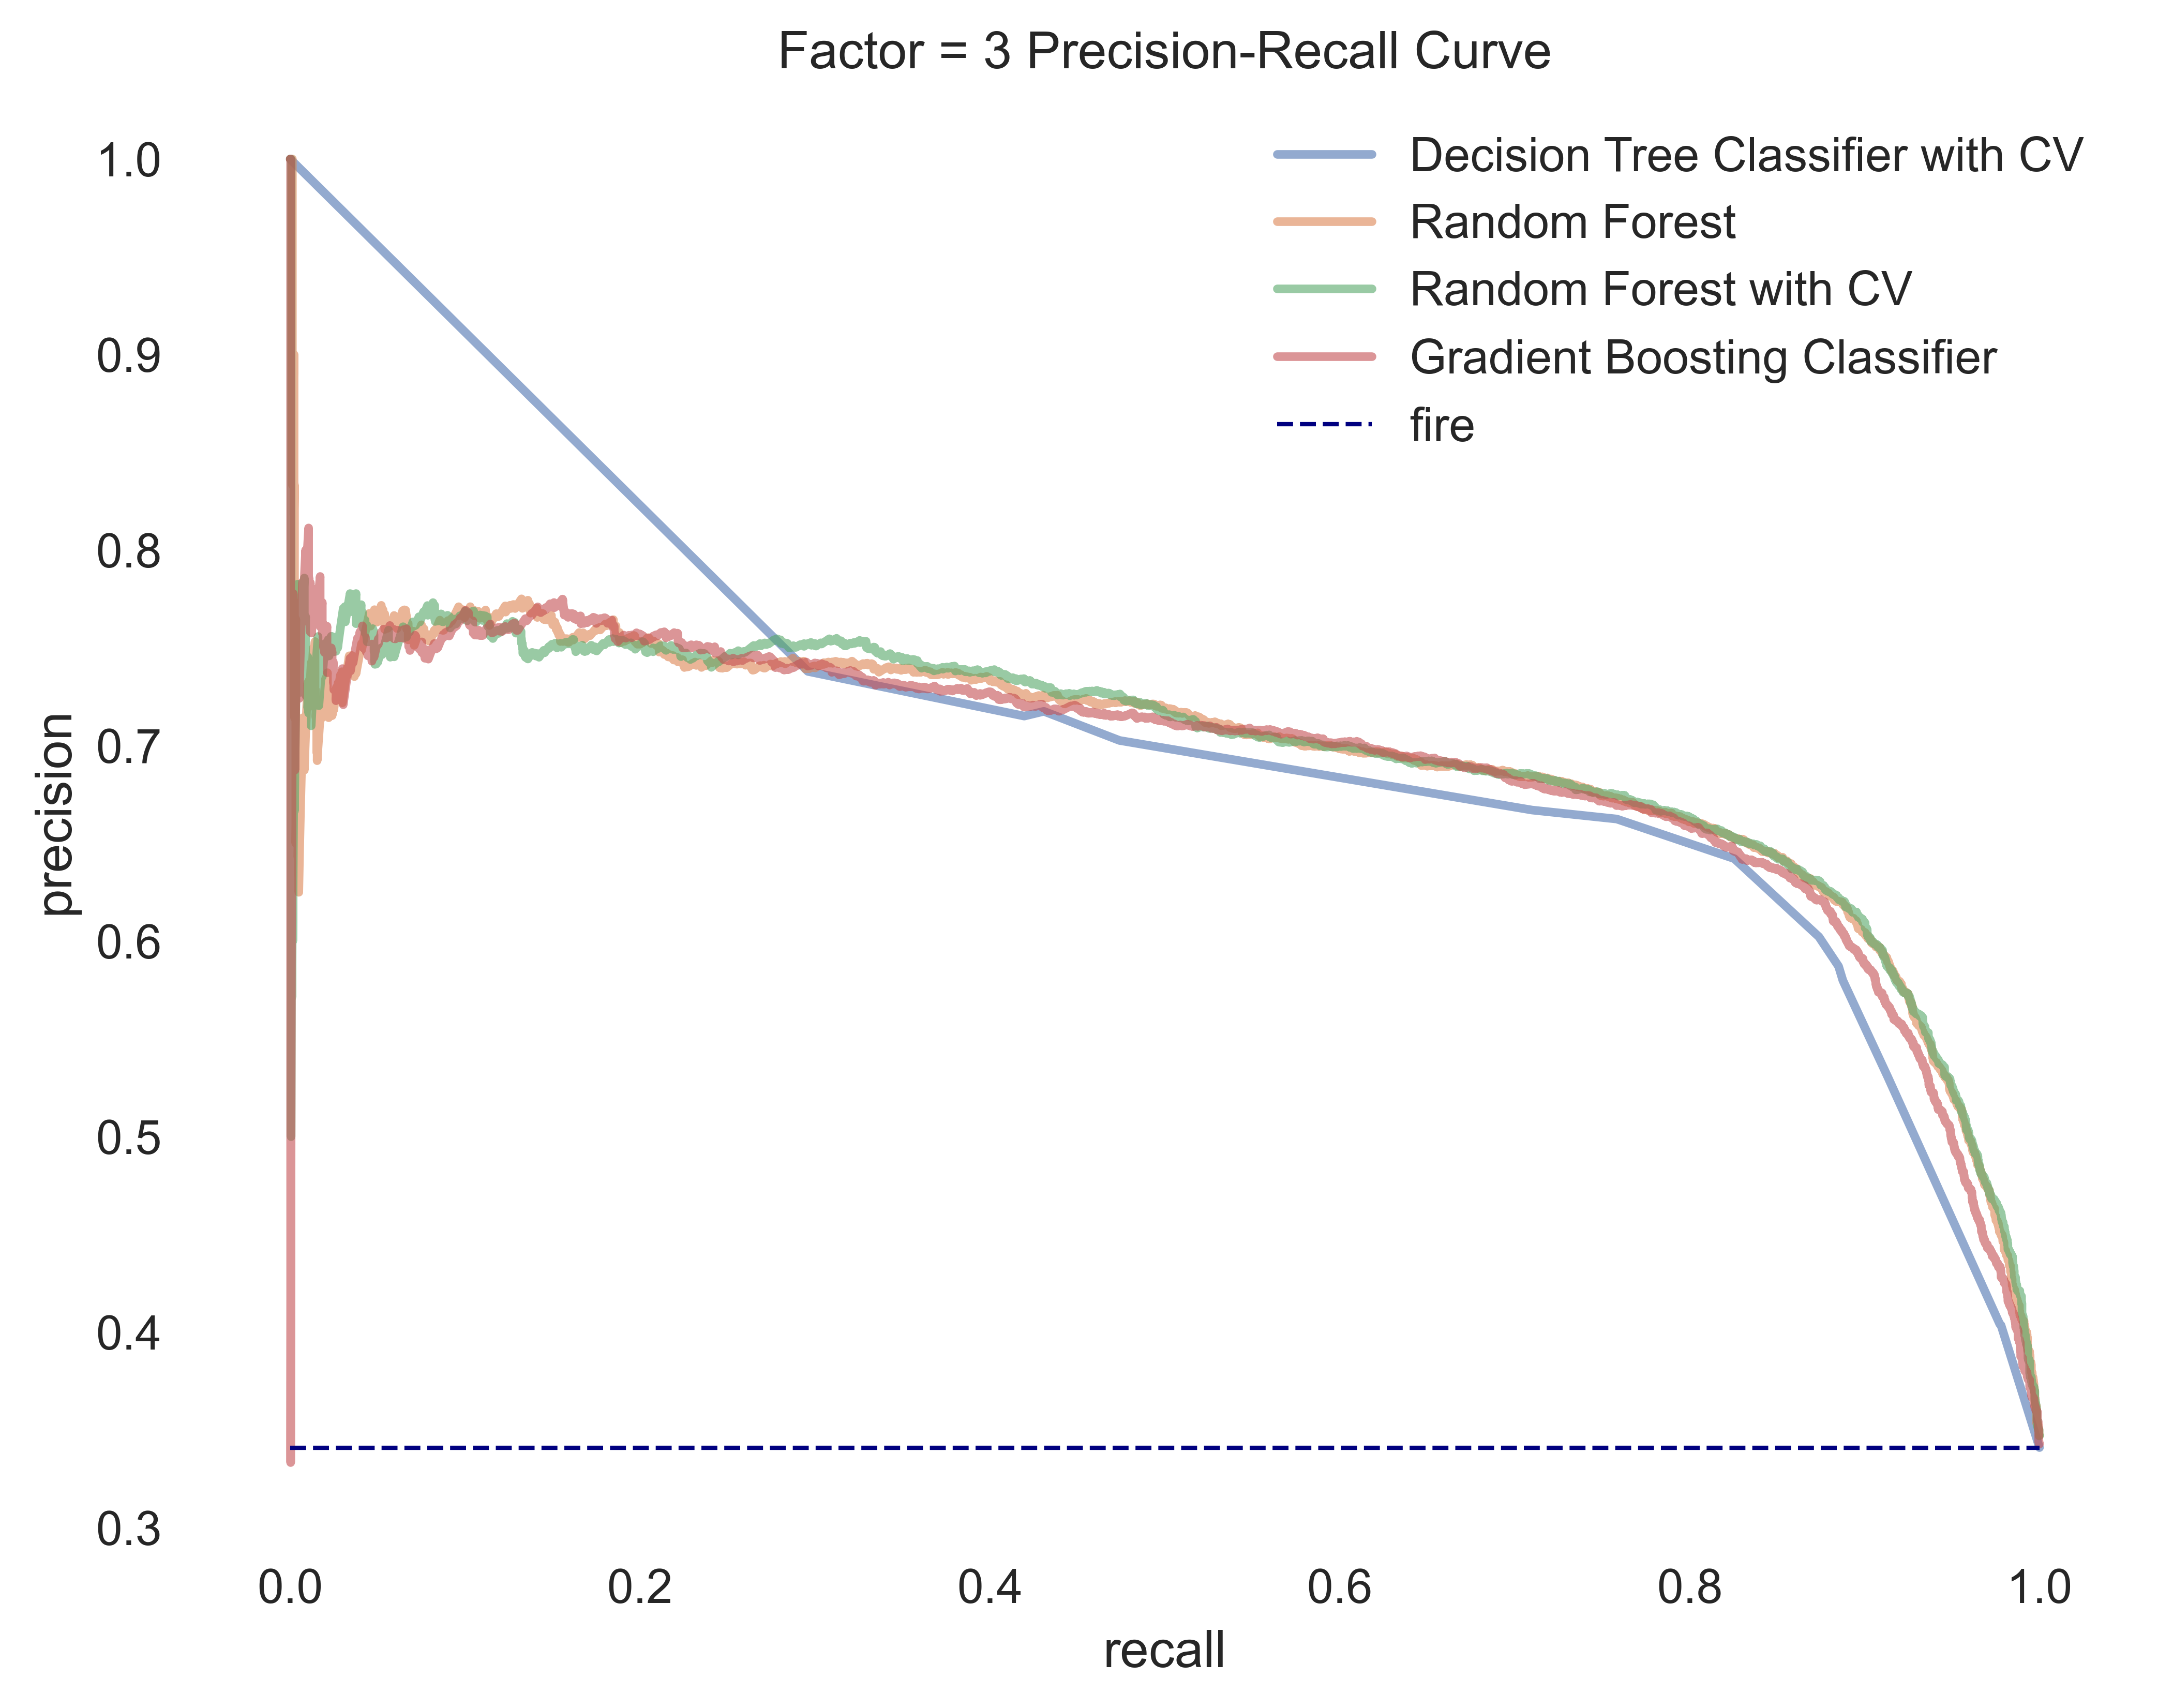

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fire = sum(y_test) / len(y_test)
for m in range(len(models)):
    y_prob = list(models.values())[m].predict_proba(X_test)[:,1]
    y_pred = list(models.values())[m].predict(X_test)
    precision, recall, threshold = precision_recall_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(recall, precision, lw=2, alpha=0.6,
            label=f'{list(models.keys())[m]}')
ax.plot([0, 1], [fire, fire], color='navy', lw=1, 
         linestyle='--', label='fire')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Factor = 3 Precision-Recall Curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc='upper right')
plt.show()

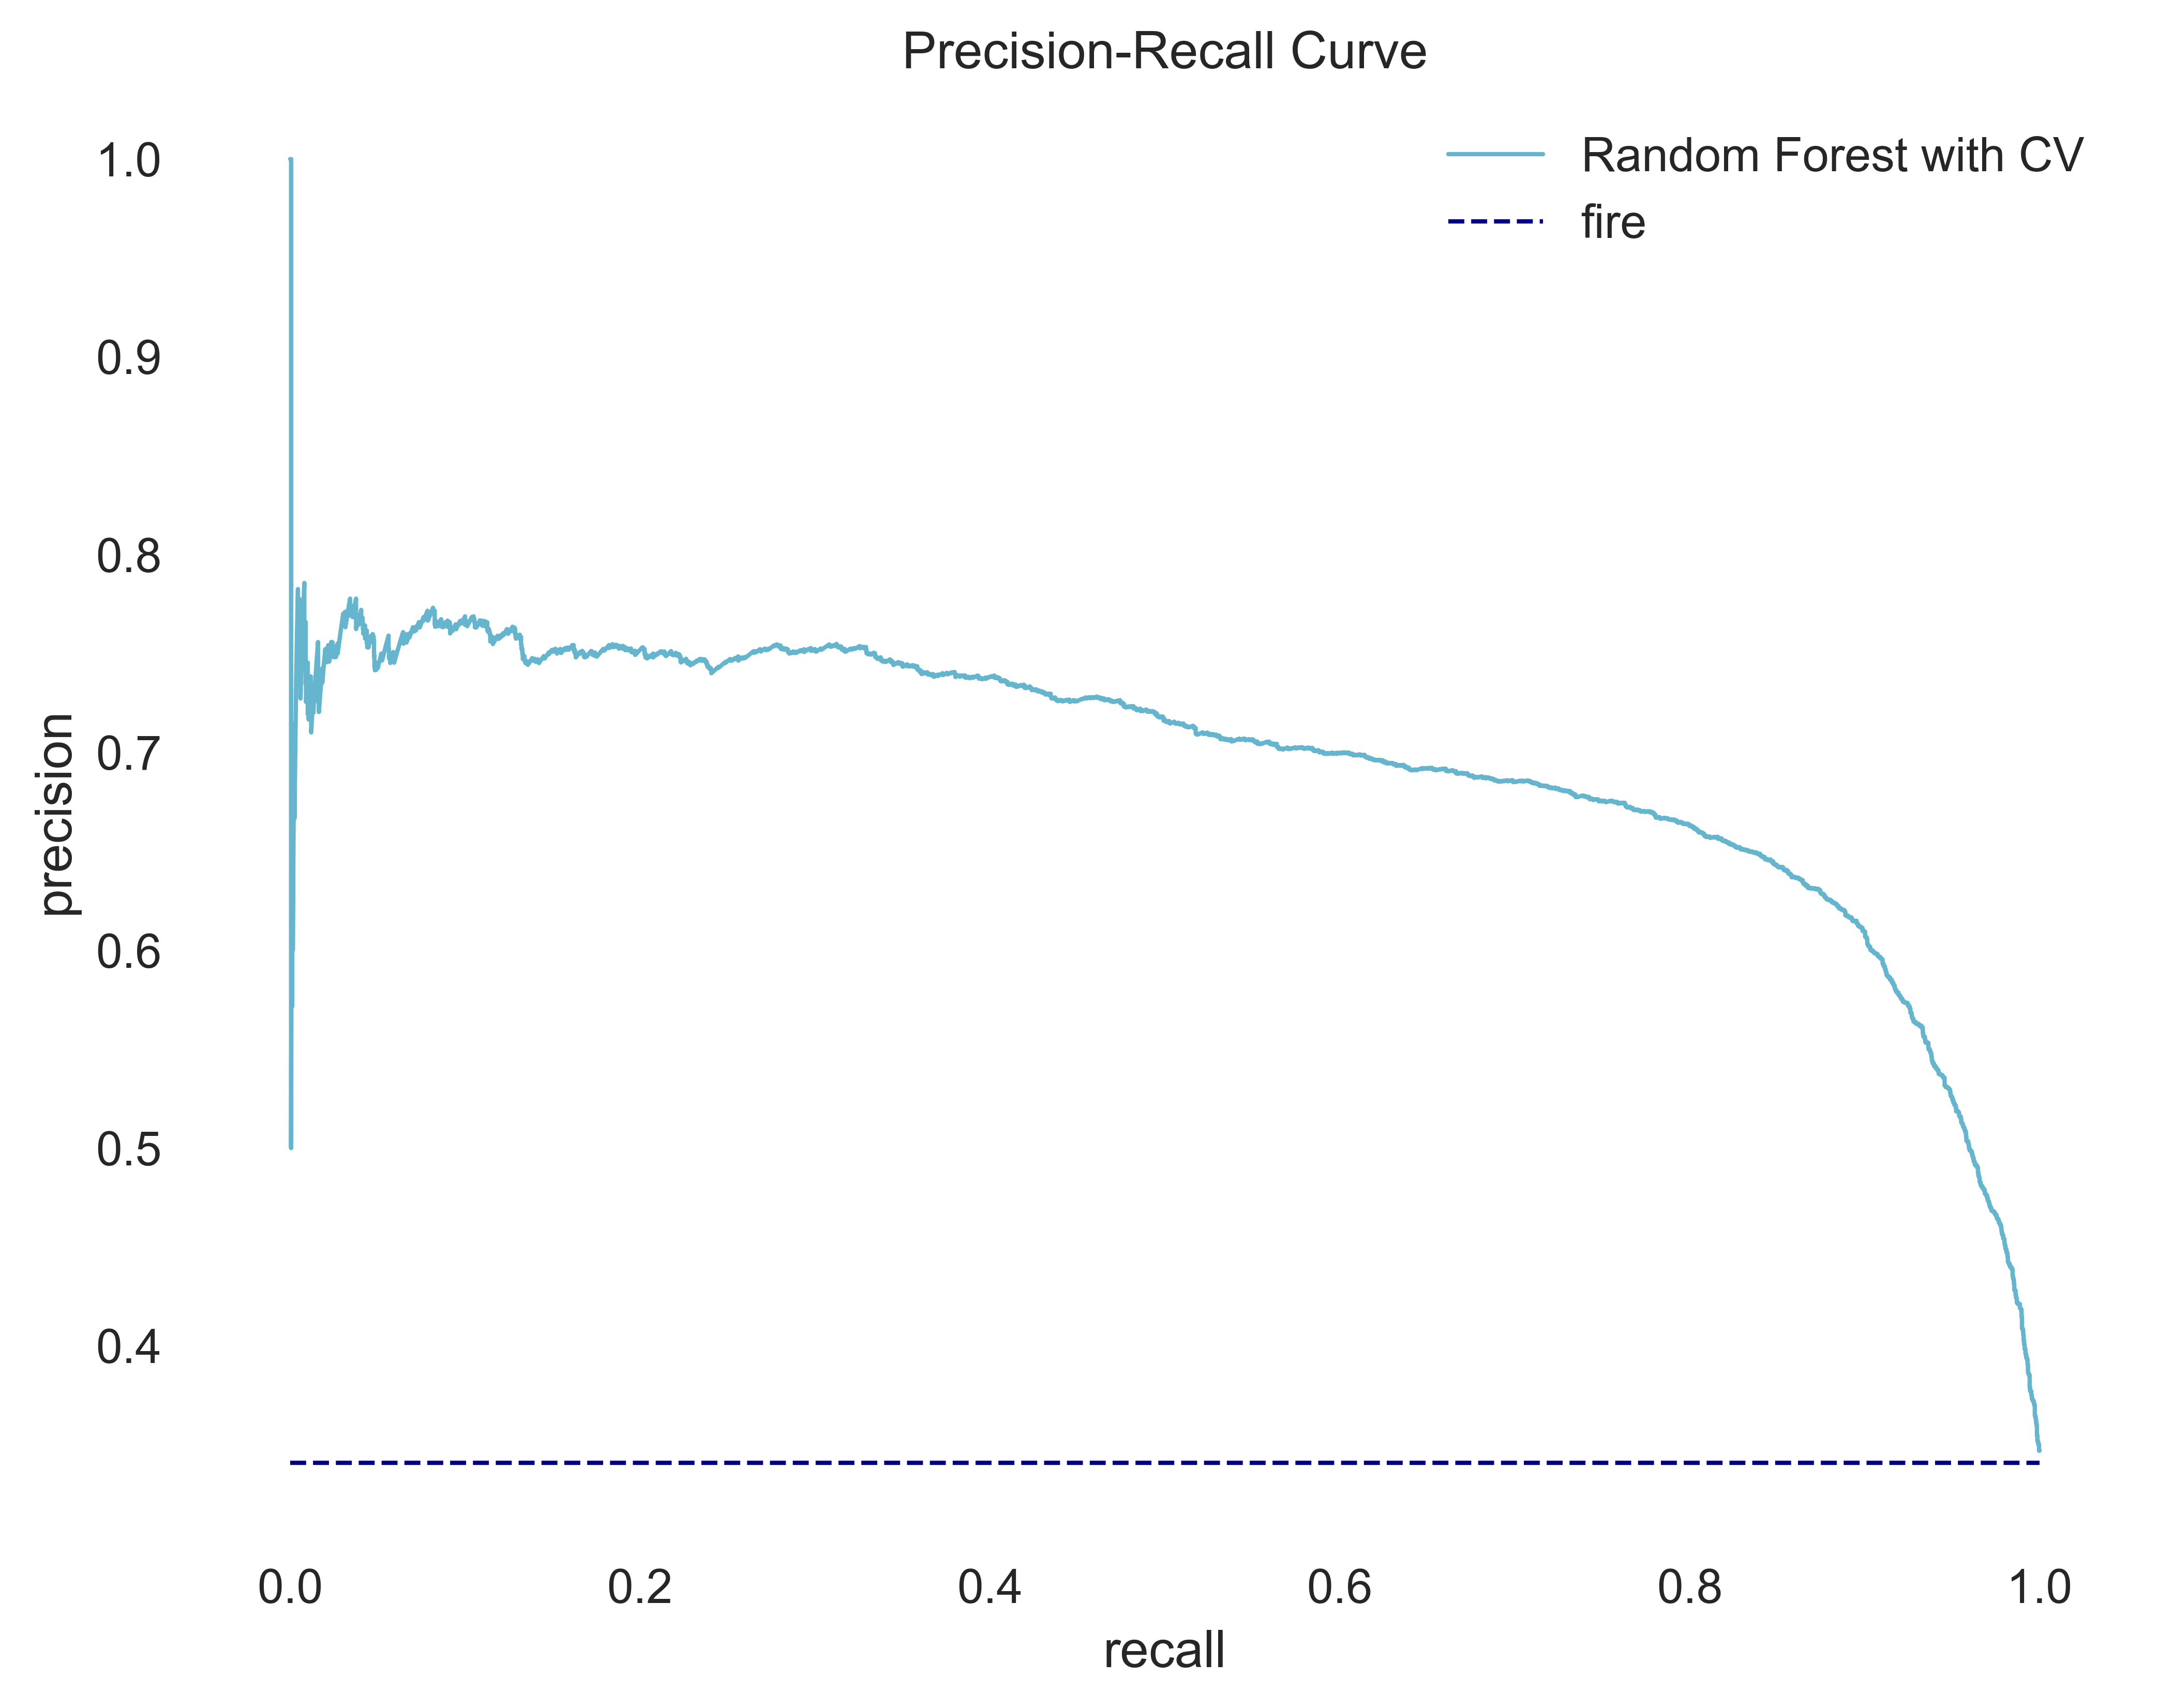

In [37]:
y_prob = rf_cv.predict_proba(X_test)[:,1]
y_pred = rf_cv.predict(X_test)
precision, recall, threshold = precision_recall_curve(y_test, y_prob)
fire = sum(y_test) / len(y_test)
plt.plot(recall, precision, color='c', lw=1, 
         label='Random Forest with CV')
plt.plot([0, 1], [fire, fire], color='navy', lw=1, 
         linestyle='--', label='fire')
plt.title('Precision-Recall Curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc='upper right')
plt.show()